# Analyzing metabolite exchanges in a host-microbe model of the human gut

This notebook performs the analysis of metabolite exchanges in the human gut presented in our paper:

O. Øyås, A. Theorell, and J. Stelling. "Scalable enumeration and sampling of minimal metabolic pathways for organims and communities". *bioRxiv* (2024).

In [1]:
import cobra
import gurobipy as grb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from collections import defaultdict, OrderedDict
from importlib import reload
from itertools import combinations, product, chain
from matplotlib import rcParams
from met_brewer import met_brew
from os.path import join
from scipy.stats import f_oneway

from mptool import *

%matplotlib inline

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'

results_dir = 'results'

## Load or build host-microbe model

(['ST', 'FP', 'LL', 'LP', 'EC', 'BT', 'HS'], 'HS_BT_EC_FP_LL_LP_ST')

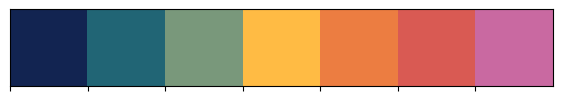

In [2]:
# Define model order, ID, and palettes

model_order = ['HS', 'BT', 'EC', 'FP', 'LL', 'LP', 'ST']

model_id = '_'.join(model_order)

# model_palette = dict(zip(model_order, sns.color_palette('Dark2', len(model_order))))
# model_palette = dict(zip(model_order, reversed(met_brew(name='Thomas', n=len(model_order), brew_type='discrete'))))
model_palette = dict(zip(model_order, reversed(met_brew(name='Cross', n=len(model_order), brew_type='continuous'))))
# model_palette['HS'] = met_brew(name='VanGogh2', n=len(model_order) + 1, brew_type='discrete')[-1]
# model_palette_pale = dict(zip(model_order, sns.color_palette('Set2', len(model_order))))
# model_palette_pale = dict(zip(model_order, met_brew(name='Klimt', n=len(model_order), brew_type='discrete')))
sns.palplot(model_palette.values())
# sns.palplot(model_palette_pale.values())

# Models ordered by increasing size
model_order = ['ST', 'FP', 'LL', 'LP', 'EC', 'BT', 'HS']

model_order, model_id


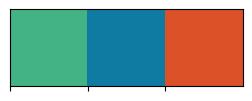

In [3]:
# Define step palettes
# step_palette = list(reversed(sns.color_palette('Set1', 3)))
step_palette = list(reversed(met_brew('Egypt', n=3, brew_type='discrete')))
# step_palette_pale = list(reversed(sns.color_palette('Pastel1', 3)))
sns.palplot(step_palette)
# sns.palplot(step_palette_pale)

In [7]:
# Build model from scratch (takes some time but needed to run all cells)?
build_model = False
build_model

True

In [8]:
# Load host-microbe model or build it from scratch

if not build_model:
    try:
        model = grb.read('models/' + model_id + '.mps')
    except grb.GurobiError:
        build_model = True

if not build_model:
    # Set model parameters
    model.setParam('OutputFlag', False)
    model.setParam('OptimalityTol', 1e-9)
    model.setParam('FeasibilityTol', 1e-9)

build_model

True

In [9]:
# Load all models (can be very slow)
models = OrderedDict()

if build_model:
    # Load human model
    models['HS'] = cobra.io.load_matlab_model('models/Recon3D_301/Recon3DModel_301.mat')

    # Load microbe models
    microbe_dir = 'models/AGORA-1.03-With-Mucins/reconstructions/sbml/'
    microbe_ids = {
        'BT': 'Bacteroides_thetaiotaomicron_VPI_5482',
        'EC': 'Escherichia_coli_str_K_12_substr_MG1655',
        'FP': 'Faecalibacterium_prausnitzii_A2_165',
        'LL': 'Lactococcus_lactis_subsp_lactis_Il1403',
        'LP': 'Lactobacillus_plantarum_WCFS1',
        'ST': 'Streptococcus_thermophilus_LMG_18311'
    }
    models.update({k: cobra.io.read_sbml_model(microbe_dir + v + '.xml') for k, v in microbe_ids.items()})

models

No defined compartments in model Recon3DModel. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


OrderedDict([('HS', <Model Recon3DModel at 0x33a1462a0>),
             ('BT',
              <Model Bacteroides_thetaiotaomicron_VPI_5482 at 0x343914920>),
             ('EC',
              <Model Escherichia_coli_str_K_12_substr_MG1655 at 0x34a4fc110>),
             ('FP',
              <Model Faecalibacterium_prausnitzii_A2_165 at 0x347176720>),
             ('LL',
              <Model Lactococcus_lactis_subsp_lactis_Il1403 at 0x3328101d0>),
             ('LP', <Model Lactobacillus_plantarum_WCFS1 at 0x33add41d0>),
             ('ST',
              <Model Streptococcus_thermophilus_LMG_18311 at 0x34c068410>)])

In [7]:
if build_model:
    # Model preprocessing

    tol = 1e-6

    for k, m in models.items():
        print(k)
        
        # Make all exchanges reversible and turn off oxygen exchange for microbes
        for r in m.exchanges:
            if k != 'HS' and r.id.startswith('EX_o2'):
                r.bounds = 0, 0
                print(r.id, r.bounds)
            else:
                r.bounds = -1000, 1000
            
    #     # Make sinks and demands irreversible
    #     for r in m.sinks:
    #         r.upper_bound = 0
    #     for r in m.demands:
    #         r.lower_bound = 0

        # Turn off non-essential sinks and demands
        sd = list(chain(m.sinks, m.demands))
        if k == 'HS':
            ne = sd
        else:
            df = cobra.flux_analysis.single_reaction_deletion(m, reaction_list=sd)
            ne = set(m.reactions.get_by_id(next(iter(x))) for x in df[df.growth.abs() > tol].ids)
        for r in ne:
            r.bounds = 0, 0
            
        # Get biomass reactions and sort by number of reactants
        bm = [(r, len(r.reactants)) for r in m.reactions if not r.boundary and 'biomass' in r.id.lower()]
        bm.sort(key=lambda x: x[1])
        
        # Set biomass reaction with largest number of reactants as objective and remove any others
        r = bm.pop()[0]
        m.objective = r
        if bm:
            m.remove_reactions([r for r, x in bm], remove_orphans=True)
        
        # Maximize growth rate
        print(m.optimize().objective_value)
        
        # Set growth requirements
        if k == 'HS':
            r.bounds = 0, 0
        else:
            r.bounds = 0.1, 0.1
        print(r.id, r.bounds)
            
        # Set non-growth-associated maintenance requirements
        r = m.reactions.DM_atp_c_
        if k == 'HS':
            r.bounds = 0.1, 0.1
        else:
            r.bounds = 0, 0
        print(r.id, r.bounds)
        
        # Check feasibility
        print(m.optimize().status)
        
        # Prefix metabolites, reactions, and genes with organism ID
        for x in chain(m.metabolites, m.reactions, m.genes):
            x.id = k + '_' + x.id
        m.repair()
        
        print()

In [8]:
if build_model:
    # Create host-microbe model
    hm = cobra.Model('_'.join(models.keys()))
    hm.compartments = {
        'c': 'cytosol',
        'l': 'lysosome',
        'm': 'mitochondria',
        'r': 'endoplasmic reticulum',
        'e': 'extracellular space',
        'x': 'peroxisome/glyoxysome',
        'n': 'nucleus',
        'g': 'golgi apparatus',
        'i': 'inner mitochondrial compartment'
    }

    # Add models to host-microbe model
    for k, m in models.items():
        print(m.id)
        hm.merge(m)
    hm

    # Check feasibility
    print(hm.optimize().status)

In [9]:
if build_model:
    # Add shared compartment
    hm.compartments.update({'s': 'shared'})

    # Get external exchanges
    x = defaultdict(list)
    for r in hm.exchanges:
        if not np.any(r.bounds):
            continue
        try:
            m = r.reactants[0]
        except IndexError:
            continue
        x[m.id[3:-3]].append(m.id[:2])

    # Add exchanges through shared compartment
    new = []
    skip = set(['12dgr180', 'arab', 'atp', 'biomass', 'ca2', 'cd2', 'cl',
                'co2', 'cobalt2', 'cu', 'cu2', 'fe2', 'fe3', 'fru', 'gal',
                'glc_D', 'h', 'h2', 'h2o','h2o2', 'h2s', 'hg2', 'k', 'malt',
                'malttr', 'man', 'mg2', 'mn1', 'mn2', 'mqn7', 'na1', 'nh4',
                'no', 'no2', 'no3', 'o2', 'o2s', 'pheme', 'pi', 'ppi', 'q8',
                'sheme', 'so4', 'xyl_D', 'zn2'])

    for m_id, l in x.items():
        if m_id in skip:
            continue

        if len(l) > 1:
            m1 = cobra.Metabolite(m_id + '[s]')
            m1.compartment = 's'

            for k in l:
                m2 = hm.metabolites.get_by_id(k + '_' + m_id + '[e]')
                iex = cobra.Reaction('_'.join([k, 'IEX', m_id]))
                iex.add_metabolites({m1: 1, m2: -1})
                if k == 'HS':
                    iex.bounds = -1000, 0
                else:
                    iex.bounds = -1000, 1000
                new.append(iex)
    hm.add_reactions(new)
    print(len(new))

    # Check feasibility
    print(hm.optimize().status)

In [10]:
if build_model:
    # Make host-microbe model irreversible
    print(len(hm.reactions))
    make_irreversible(hm)
    print(len(hm.reactions))

In [11]:
if build_model:
    # Create and save Gurobi model
    model = create_lp(hm)
    model.setParam('OutputFlag', False)
    model.setParam('OptimalityTol', 1e-9)
    model.setParam('FeasibilityTol', 1e-9)
    # model.setParam('NumericFocus', 3)

    # Save Gurobi model (note that parameter values are not saved)
    model.write('models/' + model.modelName + '.mps')
    model.write('models/' + model.modelName + '.lp')

## Solve and constrain host-microbe model

In [10]:
model = grb.read('models/HS_BT_EC_FP_LL_LP_ST.mps')
model.setParam('OutputFlag', False)
model.setParam('OptimalityTol', 1e-9)
model.setParam('FeasibilityTol', 1e-9)
model

Read MPS format model from file models/HS_BT_EC_FP_LL_LP_ST.mps
Reading time = 0.04 seconds
HS_BT_EC_FP_LL_LP_ST: 13857 rows, 33272 columns, 111146 nonzeros


<gurobi.Model Continuous instance HS_BT_EC_FP_LL_LP_ST: 13857 constrs, 33272 vars, Parameter changes: FeasibilityTol=1e-09, OptimalityTol=1e-09, Username=(user-defined), OutputFlag=0>

In [13]:
# Fractional deviation from minima allowed 
alpha = 0

In [14]:
# Minimize internal microbial fluxes
inr = [v for v in model.getVars()
       if model.getCol(v).size() > 1 and not ('IEX' in v.varName or v.varName.startswith('HS_'))]
model.setObjective(grb.LinExpr(np.ones(len(inr)), inr))
model.ModelSense = 1

model.setParam('OptimalityTol', 1e-9)
model.setParam('FeasibilityTol', 1e-9)
model.setParam('OutputFlag', True)

model.optimize()

model.setParam('OutputFlag', False)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 13857 rows, 33272 columns and 111146 nonzeros
Model fingerprint: 0x64ed3842
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 1e+03]
  RHS range        [0e+00, 0e+00]
Presolve removed 8619 rows and 20223 columns
Presolve time: 0.06s
Presolved: 5238 rows, 13049 columns, 53702 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.344e+04
 Factor NZ  : 2.573e+05 (roughly 10 MB of memory)
 Factor Ops : 4.102e+07 (less than 1 second per iteration)
 Threads    : 10

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual  

In [15]:
# Constrain internal microbial fluxes to value in minimum (note that minimum is not unique)
for v in inr:
    v.lb = v.ub = v.x
    print(v.varName, v.x)
model.update()

BT_12PPDt 0.0
BT_23DHMPO 0.0
BT_23PDE2 0.0
BT_23PDE4 0.0
BT_23PDE7 0.0
BT_23PDE9 0.0
BT_26DAPLLAT 0.0
BT_2AHBUTI 0.0
BT_2MBCOATA 0.0085184
BT_2MMALD 0.0
BT_2MMALD2 0.0
BT_2OBUTt2r 0.0326984
BT_3HACPR1 0.0
BT_3HACPR2 0.0
BT_3HAD100 0.0
BT_3HAD10M11 0.0
BT_3HAD10M12 0.0085184
BT_3HAD11M12 0.008518399999999982
BT_3HAD120 0.0
BT_3HAD12M13 0.0
BT_3HAD12M14 0.0085184
BT_3HAD13M14 0.008518399999999982
BT_3HAD140 0.0
BT_3HAD14M15 0.0
BT_3HAD14M16 0.0085184
BT_3HAD15M16 0.0085184
BT_3HAD160 0.0
BT_3HAD180 0.0
BT_3HAD40 0.0
BT_3HAD4M5 0.0
BT_3HAD4M6 0.0085184
BT_3HAD5M6 0.008518399999999982
BT_3HAD60 0.0
BT_3HAD6M7 0.0
BT_3HAD6M8 0.0085184
BT_3HAD7M8 0.008518399999999982
BT_3HAD80 0.0
BT_3HAD8M10 0.0085184
BT_3HAD8M9 0.0
BT_3HAD9M10 0.008518399999999982
BT_3MOBS 0.0
BT_3OAACPR1 0.0
BT_3OAACPR2 0.0
BT_3OAR100 0.0
BT_3OAR10M11 0.0
BT_3OAR10M12 0.0085184
BT_3OAR11M12 0.008518399999999982
BT_3OAR120 0.0
BT_3OAR12M13 0.0
BT_3OAR12M14 0.0085184
BT_3OAR13M14 0.008518399999999982
BT_3OAR140 0.0100044
BT

In [16]:
# # Constrain internal fluxes to minimum
# model.addConstr(grb.LinExpr(np.ones(len(inr)), inr), '<', (1 + alpha) * np.sum([v.x for v in inr]))
# model.update()

In [17]:
model.modelName += '_constr_1'
model.update()
model

<gurobi.Model Continuous instance HS_BT_EC_FP_LL_LP_ST_constr_1: 13857 constrs, 33272 vars, Parameter changes: FeasibilityTol=1e-09, OptimalityTol=1e-09, Username=(user-defined), OutputFlag=0>

In [18]:
# Save Gurobi model (note that parameter values are not saved)
model.write('models/' + model.modelName + '.mps')
model.write('models/' + model.modelName + '.lp')

In [19]:
# Minimize external uptake fluxes
exr = [v for v in model.getVars() if model.getCol(v).size() == 1 and v.varName.endswith('_rev') and not '[s]' in v.varName]
model.setObjective(grb.LinExpr(np.ones(len(exr)), exr))
model.ModelSense = 1

model.setParam('OptimalityTol', 1e-9)
model.setParam('FeasibilityTol', 1e-9)
model.setParam('OutputFlag', True)

model.optimize()

model.setParam('OutputFlag', False)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 13857 rows, 33272 columns and 111146 nonzeros
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [9e-07, 1e+03]
  RHS range        [0e+00, 0e+00]
LP warm-start: use basis

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5273910e+06   8.052240e+06   0.000000e+00      0s
   11286    4.1930518e+01   0.000000e+00   0.000000e+00      1s

Solved in 11286 iterations and 1.00 seconds (1.72 work units)
Optimal objective  4.193051771e+01


In [20]:
# Constrain external uptake fluxes to minimum
model.addConstr(grb.LinExpr(np.ones(len(exr)), exr), '<', (1 + alpha) * np.sum([v.x for v in exr]))
model.update()

/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_79184/1670647144.py:2: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  model.addConstr(grb.LinExpr(np.ones(len(exr)), exr), '<', (1 + alpha) * np.sum([v.x for v in exr]))


In [21]:
model.modelName = model.modelName.replace('1', '2')
model.update()
model

<gurobi.Model Continuous instance HS_BT_EC_FP_LL_LP_ST_constr_2: 13858 constrs, 33272 vars, Parameter changes: FeasibilityTol=1e-09, OptimalityTol=1e-09, Username=(user-defined), OutputFlag=0>

In [31]:
# Save Gurobi model (note that parameter values are not saved)
model.write('models/' + model.modelName + '.mps')
model.write('models/' + model.modelName + '.lp')

## Sample MPs in unconstrained or partially constrained host-microbe model 

In [22]:
# Choose and load model
model = grb.read('models/HS_BT_EC_FP_LL_LP_ST.mps')
model.setParam('OptimalityTol', 1e-9)
model.setParam('FeasibilityTol', 1e-9)
model.setParam('OutputFlag', False)
model

Read MPS format model from file models/HS_BT_EC_FP_LL_LP_ST.mps
Reading time = 0.03 seconds
HS_BT_EC_FP_LL_LP_ST: 13857 rows, 33272 columns, 111146 nonzeros
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09


<gurobi.Model Continuous instance HS_BT_EC_FP_LL_LP_ST: 13857 constrs, 33272 vars, Parameter changes: FeasibilityTol=1e-09, OptimalityTol=1e-09, Username=(user-defined), OutputFlag=0>

In [23]:
# Load tight bounds or run flux variability analysis
try:
    bounds = load_bounds('data/' + model.model_Name + '_fva_bounds.csv')
except FileNotFoundError:
    bounds = fva(model, verbose=True)
    save_bounds(bounds, 'data/' + model.model_Name + '_fva_bounds.csv')
len(bounds)

33296

In [24]:
# Sample a few MPs to check runtime (should take a minute or two)

test_sampling = True

if test_sampling:
    mps, _, _ = find_mps(model, subset=set(), method='iterative', graph=False,
                        random=True, bounds=bounds, tighten=False, tol=1e-09,
                        inf=1000, threads=0, max_mps=5, max_t=0, verbose=True,
                        export=False)

HS_BT_EC_FP_LL_LP_ST
Network size: 33272
Subset size: 33272

Making subset irreversible...

Network size: 33273
Subset size: 30094

Finding MPs...
1 ['BT_12PPDt_rev', 'BT_AACPS7', 'BT_ACCOAC', 'BT_ACGAM2E', 'BT_ACGAMtr2', 'BT_ACGS', 'BT_ACLS_b_rev', 'BT_ACOAAGPAT180', 'BT_ACODAr', 'BT_ACt2r_rev', 'BT_ADK1', 'BT_ADK3_rev', 'BT_ADNCNT3tc_rev', 'BT_ADSL1r', 'BT_ADSL2r', 'BT_ADSS', 'BT_AIRC4', 'BT_ALACI', 'BT_ARGt2r', 'BT_ASNt2r', 'BT_CDCA7aHSDHe_rev', 'BT_CHRPL', 'BT_CO2t_rev', 'BT_CS4TASE2', 'BT_CTPS1', 'BT_CYSt2r', 'BT_CYTD', 'BT_DAPDC', 'BT_DDCAt', 'BT_DHAD1', 'BT_DHNPA', 'BT_DHPS', 'BT_DMPPS2r', 'BT_DMQMT', 'BT_D_LACt2', 'BT_EX_12ppd_S(e)', 'BT_EX_7dhcdchol(e)_rev', 'BT_EX_C02528(e)', 'BT_EX_MGlcn7_rl(e)_rev', 'BT_EX_MGlcn88_rl(e)', 'BT_EX_acgalidour2s(e)', 'BT_EX_acgam(e)_rev', 'BT_EX_adn(e)', 'BT_EX_arg_L(e)_rev', 'BT_EX_co2(e)', 'BT_EX_cspg_b_degr(e)_rev', 'BT_EX_cys_L(e)_rev', 'BT_EX_ddca(e)_rev', 'BT_EX_duri(e)_rev', 'BT_EX_gam(e)_rev', 'BT_EX_h2(e)', 'BT_EX_h2o(e)_rev', 'BT_EX_h

In [14]:
# Estimate number of processes and runtime for parallelized sampling on server

# Total number of samples
m = 1e5

# Processes
n = 50

# Seconds per sample
dt = 120

# Samples per process
x = m / n

# Expected runtime in hours
t = x * (dt / 3600)

x, t

(2000.0, 66.66666666666667)

## Enumerate MPs in fully constrained host-microbe model

In [32]:
model = grb.read('models/HS_BT_EC_FP_LL_LP_ST_constr_2.mps')
model.setParam('OptimalityTol', 1e-9)
model.setParam('FeasibilityTol', 1e-9)
model.setParam('OutputFlag', False)
model

Read MPS format model from file models/HS_BT_EC_FP_LL_LP_ST_constr_2.mps
Reading time = 0.02 seconds
HS_BT_EC_FP_LL_LP_ST_constr_2: 13858 rows, 33272 columns, 114619 nonzeros
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09


<gurobi.Model Continuous instance HS_BT_EC_FP_LL_LP_ST_constr_2: 13858 constrs, 33272 vars, Parameter changes: FeasibilityTol=1e-09, OptimalityTol=1e-09, Username=(user-defined), OutputFlag=0>

In [33]:
# Define internal exchanges as subset for MP enumeration
subset = [v.varName for v in model.getVars() if '_IEX_' in v.varName]
print(len(subset))

3185


In [8]:
# # Load tight bounds or run flux variability analysis
# try:
#     bounds = load_bounds('data/' + model.model_Name + '_fva_bounds.csv')
# except FileNotFoundError:
#     bounds = fva(model, verbose=True)
#     save_bounds(bounds, 'data/' + model.model_Name + '_fva_bounds.csv')
# len(bounds)

In [34]:
# Set bounds to avoid time-consuming flux variability analysis
bounds = {v.varName: (v.lb, v.ub) for v in model.getVars()}

In [ ]:
# Enumerate minimal sets of exchanges
mps, mcs, complete = find_mps(model, subset=subset, method='iterative',
                              graph=True, random=False, bounds=bounds,
                              tighten=False, tol=1e-9, inf=1000, threads=0,
                              max_mps=0, max_t=0, verbose=True, export=True)

## Load sampled and enumerated MPs

In [25]:
# Maximum number of MPs to load for each step
max_mps = int(1e4)
max_mps

10000

In [26]:
# Load sampled and enumerated MPs in order of decreasing subnetwork size
mps = [None] * 3
mps

[None, None, None]

In [27]:
# Load sampled MPs from full network without additional constraints
mps[0] = set()
for x in os.listdir('data'):
    # if x.startswith(model.modelName) and '_mps_' in x:
    if x.startswith('HS_') and '_20240325_' in x and x.endswith('_mps.csv'):
        print(x)
        mps[0] |= load_sets(join('data', x))
        print(len(mps[0]))
    if len(mps[0]) >= max_mps:
        break
mps[0] = set(list(mps[0])[:max_mps])
len(mps[0])

HS_BT_EC_FP_LL_LP_ST_20_20240325_2243170409482_random_incomplete_mps.csv
2000
HS_BT_EC_FP_LL_LP_ST_17_20240325_2243168622684_random_incomplete_mps.csv
4000
HS_BT_EC_FP_LL_LP_ST_29_20240325_2243170894463_random_incomplete_mps.csv
6000
HS_BT_EC_FP_LL_LP_ST_40_20240325_2243168144991_random_incomplete_mps.csv
8000
HS_BT_EC_FP_LL_LP_ST_37_20240325_2243170731797_random_incomplete_mps.csv
10000


10000

In [28]:
# Load sampled MPs from exchange subnetwork with minimal microbial intracellular flux
mps[1] = set()
for x in os.listdir('data'):
    # if x.startswith(model.modelName) and '_mps_' in x:
    if x.startswith('HS_') and '_20240404_' in x and x.endswith('_mps.csv'):
        print(x)
        mps[1] |= load_sets(join('data', x))
        print(len(mps[1]))
    if len(mps[1]) >= max_mps:
        break
mps[1] = set(list(mps[1])[:max_mps])
len(mps[1])

HS_BT_EC_FP_LL_LP_ST_constr_1_47_20240404_1115323187826_random_incomplete_mps.csv
2000
HS_BT_EC_FP_LL_LP_ST_constr_1_24_20240404_1115322690132_random_incomplete_mps.csv
4000
HS_BT_EC_FP_LL_LP_ST_constr_1_17_20240404_1115322402816_random_incomplete_mps.csv
6000
HS_BT_EC_FP_LL_LP_ST_constr_1_43_20240404_1115319181874_random_incomplete_mps.csv
8000
HS_BT_EC_FP_LL_LP_ST_constr_1_11_20240404_1115323357263_random_incomplete_mps.csv
10000


10000

In [29]:
# Load enumerated MPs from subnetwork of internal exchanges with minimal external exchange flux
mps[2] = load_sets('data/HS_BT_EC_FP_LL_LP_ST_constr_2_20240410_1055101248798_complete_mps.csv')
len(mps[2])

252

## Analyze sampled and enumerated MPs by constraint step

In [30]:
# Count reactions (subnetwork sizes)
c = defaultdict(int)
c['exchange_int'] = len([v for v in model.getVars() if '_IEX_' in v.varName])
c['exchange_ext'] = len([v for v in model.getVars() if model.getCol(v).size() == 1])
c['exchange_tot'] = c['exchange_ext'] + c['exchange_int']
c['total'] = len(model.getVars())
c['intracellular'] = c['total'] - c['exchange_tot']
# c['exchange_int'] = len([r for r in hm.reactions if '_IEX_' in r.id])
# c['exchange_tot'] = len(hm.boundary) + c['exchange_int']
# c['intracellular'] = len(hm.reactions) - c['exchange_tot']
# c['total'] = len(hm.reactions)

# Count MPs
d = defaultdict(list)
for i in range(len(mps)):
    print(i)
    d['step'].append(i + 1)
    d['mps'].append(len(mps[i]))

d['subset_size'] = [c['total'], c['exchange_tot'], c['exchange_int']]

df = pd.DataFrame(d)
df['log_mps'] = np.log10(df.mps)
df['log_subset_size'] = np.log10(df.subset_size)

step_df = df
step_df

0
1
2


step    mps  subset_size   log_mps  log_subset_size
0     1  10000        33272  4.000000         4.522079
1     2  10000        10452  4.000000         4.019199
2     3    252         3185  2.401401         3.503109

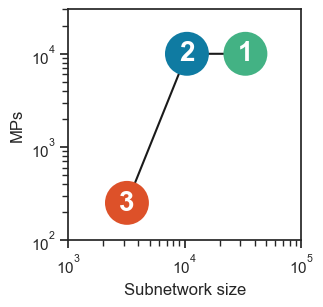

In [31]:
sns.set_theme(context='notebook', style='ticks', font_scale=1)

f = plt.figure()

df = step_df
s = 1000

x = 'subset_size'
y = 'mps'
hue = 'step'

ax = sns.scatterplot(x=x, y=y, hue=hue, data=df, palette=step_palette, s=s, lw=0)
ax = sns.lineplot(x=x, y=y, data=df, color='k', ls='-', zorder=-1)

for i, row in df.iterrows():
    plt.text(row[x], row[y], str(i + 1), c='w', ha='center', va='center', weight='bold', fontsize=20)

# plt.xlim(-s * 2, 37000 + s)
# plt.ylim(-s * 15, 1e5 + s * 15)
# plt.xlim(3, 5)
# plt.ylim(2, 5.4)
plt.xlim(1e3, 1e5)
plt.ylim(1e2, 3 * df.mps.max())
plt.xlabel('Subnetwork size')
plt.ylabel('MPs')
plt.xscale('log')
plt.yscale('log')

ax.legend().set_visible(False)

f.set_size_inches(3, 3)
f.savefig(join(results_dir, 'subset_size_mps.svg'), bbox_inches='tight')

In [32]:
d = defaultdict(list)
for i in range(len(mps)):
    d['mp'].extend(range(len(mps[i])))
    d['step'].extend([i + 1] * len(mps[i]))
    d['reactions'].extend([len(mp) for mp in mps[i]])
df = pd.DataFrame(d)
df['log_reactions'] = np.log10(df.reactions)
size_df = df
size_df

mp  step  reactions  log_reactions
0        0     1       2085       3.319106
1        1     1       2063       3.314499
2        2     1       2095       3.321184
3        3     1       2130       3.328380
4        4     1       2109       3.324077
...    ...   ...        ...            ...
20247  247     3         19       1.278754
20248  248     3         21       1.322219
20249  249     3         21       1.322219
20250  250     3         21       1.322219
20251  251     3         19       1.278754

[20252 rows x 4 columns]

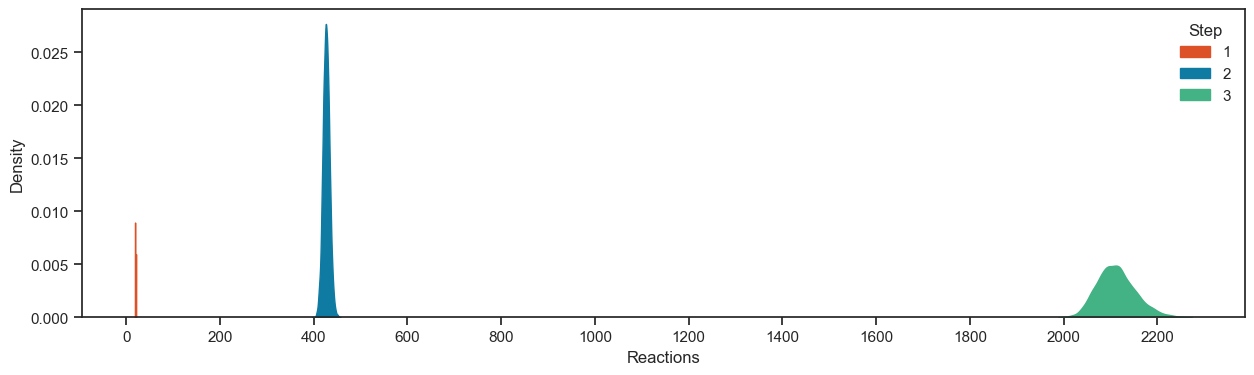

In [33]:
sns.set_theme(context='notebook', style='ticks', font_scale=1)

f = plt.figure()

df = size_df

ax = sns.kdeplot(x=df.reactions, hue=df.step, palette=step_palette, fill=True, alpha=1, cut=True, common_norm=True)
# ax = sns.ecdfplot(x=df.reactions, hue=df.step, palette=step_palette)

# plt.xlim(0, 2300)
plt.xticks(np.arange(0, 2400, 200))
plt.xlabel('Reactions')

ax.legend(range(1, 4), title='Step', frameon=False)

f.set_size_inches(15, 4)
f.savefig(join(results_dir, 'mp_size_step.svg'), bbox_inches='tight')

In [34]:
# Compute reaction frequencies
reac_frac = [None] * 3
for i in range(len(mps)):
    print(i)
    d = defaultdict(float)
    for mp in mps[i]:
        for x in mp:
            d[x] += 1 / len(mps[i])
    reac_frac[i] = d
reac_frac

0
1
2


[defaultdict(float,
             {'LP_IEX_lys_L_rev': 0.21309999999999285,
              'LP_DAPDAi': 0.9999999999999062,
              'LL_EX_cl(e)_rev': 0.9999999999999062,
              'LP_CA2abc': 0.9999999999999062,
              'LL_AIHDUPDG': 0.9999999999999062,
              'LP_GLUR_rev': 0.9999999999999062,
              'ST_IEX_lys_L': 0.17159999999999742,
              'LL_PRAI': 0.9999999999999062,
              'BT_SPMDabc': 0.9999999999999062,
              'FP_EX_ser_L(e)_rev': 0.38639999999997376,
              'LP_EX_mg2(e)_rev': 0.9999999999999062,
              'LP_r0488_rev': 0.9999999999999062,
              'BT_UAAGDS': 0.9999999999999062,
              'ST_ASPt2r': 0.384399999999974,
              'ST_ASPTA': 0.4995999999999613,
              'EC_THRAi': 0.20249999999999402,
              'LP_DCMPDA': 0.23779999999999013,
              'LL_IHDUDPMG': 0.9999999999999062,
              'BT_GTPCI': 0.9999999999999062,
              'LL_IEX_pydx_rev': 0.26129999999

In [35]:
df = pd.DataFrame(reac_frac).reset_index().melt(id_vars='index').fillna(0)
df.columns = ['step', 'reaction', 'frac']
df.step += 1
df['log_frac'] = np.log10(df.frac)
frac_df = df
frac_df

/opt/homebrew/Caskroom/miniconda/base/envs/mptool/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


step               reaction    frac      log_frac
0         1       LP_IEX_lys_L_rev  0.2131 -6.714166e-01
1         2       LP_IEX_lys_L_rev  0.4768 -3.216638e-01
2         3       LP_IEX_lys_L_rev  0.0000          -inf
3         1              LP_DAPDAi  1.0000 -4.074284e-14
4         2              LP_DAPDAi  0.0000          -inf
...     ...                    ...     ...           ...
66751     2  HS_EX_n5m2masn[e]_rev  0.0001 -4.000000e+00
66752     3  HS_EX_n5m2masn[e]_rev  0.0000          -inf
66753     1       HS_EX_pvsgluc[e]  0.0000          -inf
66754     2       HS_EX_pvsgluc[e]  0.0001 -4.000000e+00
66755     3       HS_EX_pvsgluc[e]  0.0000          -inf

[66756 rows x 4 columns]

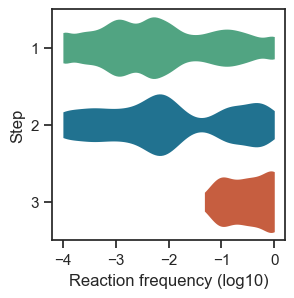

In [147]:
f = plt.figure()

df = frac_df
# df = df[df.step < 2]
ax = sns.violinplot(x='log_frac', y='step', hue='step', order=range(1, 4), orient='h', data=df, palette=step_palette, inner=None, cut=0, linewidth=0)

# df = frac_df
# df = df[df.step == 2]
# ax = sns.swarmplot(x='log_frac', y='step', hue='step', orient='h', data=df, palette=step_palette[2:])

# plt.xticks(range(-5, 1, 1))
# plt.xlim(1e3, 1e5)
# plt.ylim(1e2, 3e5)
plt.xlabel('Reaction frequency (log10)')
plt.ylabel('Step')

ax.legend().set_visible(False)

f.set_size_inches(3, 3)
f.savefig(join(results_dir, 'frequency_step.svg'), bbox_inches='tight')

## Analyze sampled and enumerated MPs by organism and reaction type

In [12]:
# Choose constraint step to analyze further and number of MPs to analyze
step = 3
max_mps = int(1e4)
step, max_mps

(3, 10000)

In [127]:
# Build MP data frame (passing a generator to limit memory use)
df = pd.DataFrame({x: 1 for x in mp} for mp in list(mps[step - 1])[:max_mps]).fillna(0).astype(int)
df = df.loc[:, ~(df.columns.str.contains('dreplication') | df.columns.str.contains('rtranscription') | df.columns.str.contains('pbiosynthesis'))]
mp_df = df
mp_df

FP_IEX_ile_L_rev  ST_IEX_etoh  LL_IEX_ile_L  FP_IEX_orn_rev  \
0                   1            1             1               1   
1                   1            1             1               1   
2                   0            1             1               1   
3                   0            1             1               1   
4                   1            1             1               1   
..                ...          ...           ...             ...   
247                 0            1             1               1   
248                 0            1             1               1   
249                 0            1             1               1   
250                 0            1             1               1   
251                 0            1             1               1   

     ST_IEX_ala_L  FP_IEX_gly_rev  EC_IEX_etoh_rev  FP_IEX_nac_rev  \
0               1               1                1               1   
1               1               1                1               1   
2               1               1                1               1   
3               1               1                1               1   
4               1               1                1               1   
..            ...             ...              ...             ...   
247             1               1                1               1   
248             1               1                1               1   
249             1               1                1               1   
250             1               1                1               1   
251             1               1                1               1   

     HS_IEX_orn_rev  ST_IEX_acald_rev  ...  LL_IEX_for  LP_IEX_ile_L_rev  \
0                 1                 1  ...           0                 0   
1                 1                 1  ...           0                 0   
2                 1                 1  ...           0                 0   
3                 1                 1  ...           0                 0   
4                 1                 1  ...           1                 0   
..              ...               ...  ...         ...               ...   
247               1                 1  ...           1                 1   
248               1                 1  ...           0                 0   
249               1                 1  ...           0                 0   
250               1                 1  ...           0                 0   
251               1                 1  ...           0                 1   

     HS_IEX_gly_rev  ST_IEX_for  FP_IEX_for  LL_IEX_ppa  HS_IEX_ppa_rev  \
0                 0           0           0           0               0   
1                 0           0           0           0               0   
2                 0           0           0           0               0   
3                 0           0           0           0               0   
4                 0           0           0           0               0   
..              ...         ...         ...         ...             ...   
247               0           0           0           0               0   
248               0           0           0           0               0   
249               0           0           0           1               1   
250               0           0           0           0               0   
251               0           1           0           0               0   

     LL_IEX_succ  FP_IEX_glyc  LP_IEX_for  
0              0            0           0  
1              0            0           0  
2              0            0           0  
3              0            0           0  
4              0            0           0  
..           ...          ...         ...  
247            0            0           0  
248            0            1           0  
249            0            0           0  
250            0            1           0  
251            0            0           0  

[252

In [294]:
if step < 3:
    # Check convergence of reaction frequencies in subsamples by bootstrapping

    d = defaultdict(list)

    # Get essential reactions
    e = [k for k, v in reac_frac[step - 1].items() if v == 1]

    # Choose subsample counts
    counts = range(100)

    # Choose 10, 100, or 1000 integer subsample sizes (filters out non-integers)
    # sizes = np.unique(np.logspace(0, np.log10(len(mp_df)), 10).astype(int))
    sizes = np.unique(np.logspace(0, np.log10(len(mp_df)), 114).astype(int))
    # sizes = np.unique(np.logspace(0, np.log10(len(mp_df)), 1509).astype(int))

    for m in counts:
        print(m)
        for n in sizes:
            # i = random.sample(range(len(samples)), int(n))
            i = random.choices(range(len(mp_df)), k=int(n))
            s = mp_df.loc[i].sum(0) / n

            # Sanity check for essential reactions
            if not (s[e] == 1).all():
                print(m, n)
                print(i)
                print(s)
                break

            s_rel = s / (mp_df.sum(0) / len(mp_df))

            d['reaction'].extend(s.index)
            d['frac'].extend(s.values)
            d['frac_rel'].extend(s_rel.values)
            d['m'].extend([m] * len(s))
            d['n'].extend([n] * len(s))
            # break

    bs_df = pd.DataFrame(d)

    # Compute log values
    bs_df['log_n'] = np.log10(bs_df.n)
    bs_df['log_frac'] = np.log10(bs_df.frac)
    bs_df['log_frac_rel'] = np.log10(bs_df.frac_rel)

    bs_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


/opt/homebrew/Caskroom/miniconda/base/envs/mptool/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/mptool/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


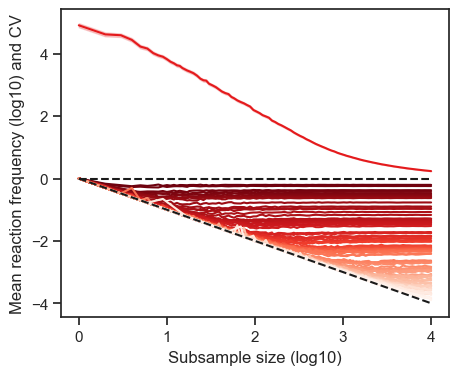

In [296]:
if step < 3:
    sns.set_theme(context='notebook', style='ticks', font_scale=1)

    # Plot convergence of reaction frequencies

    df = bs_df

    # s = random.sample(list(set(df[(df.n == df.n.max()) & (df.frac != 1)].reaction)), 10)
    # s = set(df[(df.n == df.n.max()) & (df.frac != 1)].reaction)
    s = random.sample(list(set(df[df.frac != 1].reaction)), 100)
    # s = set(df.reaction)

    f = plt.figure()

    df = df[df.reaction.isin(s)]
    hue_order = list(df[df.n == df.n.max()].groupby(['reaction']).frac.mean().sort_values(ascending=False).index)

    ax = sns.lineplot(x='log_n', y='log_frac', hue='reaction', hue_order=hue_order, data=df, errorbar=None, palette='Reds_r')

    plt.plot([0, df.log_n.max()], [0, -df.log_n.max()], c='k', ls='--')

    # ax = sns.lineplot(x='log_n', y='frac_rel', data=df)

    g = bs_df.groupby(['reaction', 'log_n'])
    df = g.frac_rel.std().reset_index()
    df.frac_rel /= g.frac_rel.mean().values

    sns.lineplot(x=df.log_n, y=df.frac_rel, color='#e41a1c')

    plt.plot([0, df.log_n.max()], [0, 0], c='k', ls='--')

    # plt.xscale('log')
    # plt.yscale('log')

    # plt.xlim(0, np.log10(len(mps[step])))
    # plt.ylim(-5, 3)

    # t = 'Minimal glucose' if medium == 'min_glc' else 'Glucose and amino acid'
    # plt.title(t + ' medium', weight='bold')
    plt.xlabel('Subsample size (log10)')
    # plt.ylabel('Mean reaction frequency (log10)    Mean CV (log10)', loc='bottom')
    plt.ylabel('Mean reaction frequency (log10) and CV', loc='center')
    # ax.text(-1, 0, 'Relative CV (log10)', rotation=90)

    # ax.set_yticklabels(['$10^{' + x.get_text() + '}$' for x in ax.get_yticklabels()])

    # plt.grid(ls='--')

    ax.legend().set_visible(False)

    f.set_size_inches(5, 4)
    f.savefig(join(results_dir, 'sampling_convergence_host_microbe_' + str(step) + '.svg'), bbox_inches='tight')

In [13]:
if step == 3:
    # Load enumeration log
    log_df = pd.read_csv('data/HS_BT_EC_FP_LL_LP_ST_constr_2_20240410_1055101248798_complete_log.csv')
    log_df['t'] = log_df.dt
    dt = [log_df.dt[0]]
    dt.extend(np.diff(log_df.dt))
    log_df['dt'] = dt
    # i = len(log_df)
    # log_df.loc[i, :] = log_df.iloc[-1, :]
    # log_df.loc[i, 'mcs'] = len(mcs)
    # log_df.loc[i, 't'] = 7493.46
    # log_df.loc[i, 'dt'] = log_df.loc[i, 't'] - log_df.loc[i - 1, 't']
log_df

mps  mcs  mp_size  subset_size  network_size        dt            t
0      1    0       21         3185         33272  4.559947     4.559947
1      2    2       19         3185         33272  3.095478     7.655425
2      3   10       21         3185         33272  7.403872    15.059297
3      4   14       19         3185         33272  6.496714    21.556011
4      5   14       19           19         33272  3.708575    25.264586
..   ...  ...      ...          ...           ...       ...          ...
247  248   42       19           19         33272  2.901295  1952.212376
248  249   42       19           19         33272  8.440091  1960.652467
249  250   42       19           19         33272  8.292503  1968.944970
250  251   42       19           19         33272  6.954324  1975.899294
251  252   42       19           19         33272  6.528592  1982.427886

[252 rows x 7 columns]

<>:11: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\G'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\G'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\D'
/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_31475/984479778.py:11: SyntaxWarning: invalid escape sequence '\P'
  ax = sns.lineplot(x=df.t, y=df.mps / df.mps.max(), color='#e41a1c', label='$\\dfrac{|\Pi|}{|\Pi_\mathregular{c}|}$', lw=2)
/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_31475/984479778.py:12: SyntaxWarning: invalid escape sequence '\G'
  ax = sns.lineplot(x=df.t, y=df.mcs / df.mcs.max(), color='#377eb8', label='$\\dfrac{|\Gamma|}{|\Gamma_\mathregu

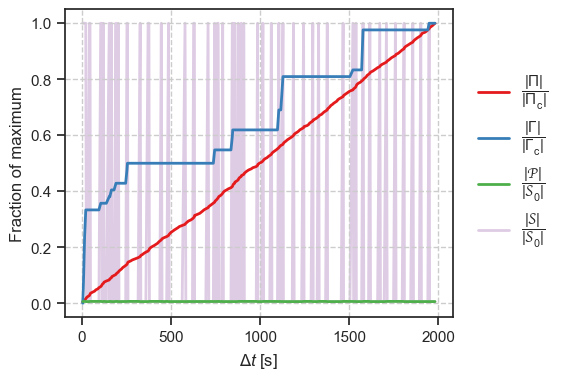

In [281]:
if step == 3:
    sns.set_theme(context='notebook', style='ticks', font_scale=1)
    f = plt.figure()

    df = log_df

    label_x = -0.5
    label_y = 1.025
    label_size = 28

    ax = sns.lineplot(x=df.t, y=df.mps / df.mps.max(), color='#e41a1c', label='$\\dfrac{|\Pi|}{|\Pi_\mathregular{c}|}$', lw=2)
    ax = sns.lineplot(x=df.t, y=df.mcs / df.mcs.max(), color='#377eb8', label='$\\dfrac{|\Gamma|}{|\Gamma_\mathregular{c}|}$', lw=2)
    ax = sns.lineplot(x=df.t, y=df.mp_size / df.subset_size.max(), color='#4daf4a', label='$\\dfrac{|\mathcal{P}|}{|\mathcal{S}_0|}$', lw=2)
    ax = sns.lineplot(x=df.t, y=df.subset_size / df.subset_size.max(), color='#decbe4', label='$\\dfrac{|\mathcal{S}|}{|\mathcal{S}_0|}$', zorder=0, lw=2)

    ax.legend(frameon=False, ncol=1, loc=(1.05, 0.2))
    # ax.legend(frameon=False, ncol=4, loc=(-0.22, -0.6))
    # ax.legend(frameon=True, ncol=2, loc=(0.5, 0.07), fontsize=16)
    # ax.text(0.6 * label_x, label_y, 'A', transform=ax.transAxes, size=label_size)
    plt.xlabel('$\Delta\it{t}$ [s]')
    plt.ylabel('Fraction of maximum')
    # plt.xlim(-100, 2000)
    plt.grid(True, ls='--')

    f.set_size_inches(5, 4)
    f.savefig(join(results_dir, 'enumeration_log_host_microbe_' + str(step) + '.svg'), bbox_inches='tight')

In [128]:
# Build data frame with reaction counts by organism and reaction type
d = defaultdict(list)

for x in model_order:
    print(x)
    df = mp_df.loc[:, mp_df.columns.str.startswith(x + '_')]

    intra = ~(df.columns.str.contains('EX_') | df.columns.str.contains('_DM_') | df.columns.str.contains('_sink_'))
    if intra.any():
        d['organism'].extend([x] * len(df))
        d['reaction_type'].extend(['intracellular'] * len(df))
        d['reactions'].extend(df.loc[:, intra].sum(1))

    ex_ext = df.columns.str.contains('_EX_') | df.columns.str.contains('_DM_') | df.columns.str.contains('_sink_')
    if ex_ext.any():
        d['organism'].extend([x] * len(df))
        d['reaction_type'].extend(['exchange_ext'] * len(df))
        d['reactions'].extend(df.loc[:, ex_ext].sum(1))

    ex_int = df.columns.str.contains('_IEX_')
    if ex_int.any():
        d['organism'].extend([x] * len(df))
        d['reaction_type'].extend(['exchange_int'] * len(df))
        d['reactions'].extend(df.loc[:, ex_int].sum(1))
        
        # d['reactions'].extend(df.sum(1))
        # d['reactions_frac'].extend(df.sum(1) / sample_df.sum(1))
        # d['exchange_ext'].extend(df.loc[:, df.columns.str.contains('_EX_') | df.columns.str.contains('_DM_') | df.columns.str.contains('_sink_')].sum(1))
        # d['exchange_int'].extend(df.loc[:, df.columns.str.contains('_IEX_')].sum(1))
        # d['intracellular'].extend(df.loc[:, ~df.columns.str.contains('EX_')].sum(1))

cnt_df = pd.DataFrame(d)
cnt_df

ST
FP
LL
LP
EC
BT
HS


organism reaction_type  reactions
0          ST  exchange_int          5
1          ST  exchange_int          4
2          ST  exchange_int          5
3          ST  exchange_int          5
4          ST  exchange_int          4
...       ...           ...        ...
1759       HS  exchange_int          2
1760       HS  exchange_int          3
1761       HS  exchange_int          3
1762       HS  exchange_int          3
1763       HS  exchange_int          2

[1764 rows x 3 columns]

In [129]:
# Write reaction count supplementary table
df = cnt_df
df['step'] = step
df = df[['step'] + list(df.columns[:-1])]
df.to_excel(join(results_dir, 'reaction_counts_host_microbe_' + str(step) + '.xlsx'), index=False)

In [283]:
if step == 1:
    sns.set_theme(context='notebook', style='ticks', font_scale=1)

    # Plot MP length distribution
    df = cnt_df

    f = plt.figure()

    # ax = sns.boxenplot(x=np.log10(df.reactions), y=df.reaction_type, hue=df.organism, hue_order=model_order, palette=model_palette)
    ax = sns.violinplot(x=np.log10(df.reactions), y=df.reaction_type, hue=df.organism, hue_order=model_order, palette=model_palette, inner=None, linewidth=0, cut=0, density_norm='width')

    plt.xlim(-0.25, 2.75)
    plt.xlabel('Reactions (log10)')
    plt.ylabel('')
    ax.set_yticklabels(['Intracellular\nreactions', 'Exchanges\n(external)', 'Exchanges\n(internal)'])

    ax.legend(frameon=False, loc='upper left', fontsize=12).set_title('')

    f.set_size_inches(4, 4)
    f.savefig(join(results_dir, 'reactions_mps_' + str(step) + '.svg'), bbox_inches='tight')

In [285]:
if step == 2:
    sns.set_theme(context='notebook', style='ticks', font_scale=1)

    # Plot MP length distribution
    df = cnt_df

    f = plt.figure()

    # ax = sns.boxenplot(x=np.log10(df.reactions), y=df.reaction_type, hue=df.organism, hue_order=model_order, palette=model_palette)
    ax = sns.violinplot(x=np.log10(df.reactions), y=df.reaction_type, hue=df.organism, hue_order=model_order, palette=model_palette, inner=None, linewidth=0, cut=0, density_norm='width')

    plt.xlim(-0.25, 2.75)
    plt.xlabel('Reactions (log10)')
    plt.ylabel('')
    ax.set_yticklabels(['Exchanges\n(external)', 'Exchanges\n(internal)'])

    ax.legend(frameon=False, loc='lower right', fontsize=12).set_title('')

    f.set_size_inches(4, 4)
    f.savefig(join(results_dir, 'reactions_mps_' + str(step) + '.svg'), bbox_inches='tight')

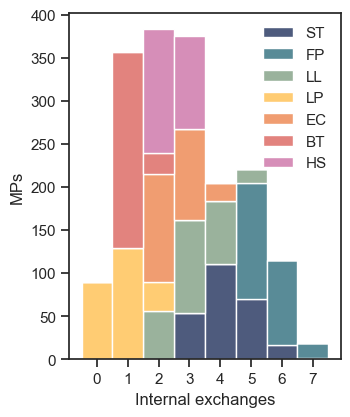

In [286]:
if step == 3:
    f = plt.figure()

    df = cnt_df

    ax = sns.histplot(x=df.reactions, hue=df.organism, palette=model_palette, hue_order=reversed(model_order), multiple='stack', binrange=(-0.5, 7.5), bins=8)

    plt.xticks(range(8))
    plt.xlabel('Internal exchanges')
    plt.ylabel('MPs')

    plt.legend([x for x in model_order], ncol=1, frameon=False)

    f.set_size_inches(3.5, 4.5)
    f.savefig(join(results_dir, 'reactions_mps_' + str(step) + '.svg'), bbox_inches='tight')

In [130]:
# Classify reactions by organism and reaction type
d = defaultdict(list)
for k, v in reac_frac[step - 1].items():
    d['reaction'].append(k)
    d['frac'].append(v)
    d['organism'].append(k[:2])
    if '_EX_' in k:
        rt = 'exchange_ext'
    elif '_IEX_' in k:
        rt = 'exchange_int'
    else:
        rt = 'intracellular'
    d['reaction_type'].append(rt)
frac_df = pd.DataFrame(d)
frac_df

reaction      frac organism reaction_type
0   FP_IEX_ile_L_rev  0.250000       FP  exchange_int
1        ST_IEX_etoh  1.000000       ST  exchange_int
2       LL_IEX_ile_L  1.000000       LL  exchange_int
3     FP_IEX_orn_rev  1.000000       FP  exchange_int
4       ST_IEX_ala_L  1.000000       ST  exchange_int
5     FP_IEX_gly_rev  1.000000       FP  exchange_int
6    EC_IEX_etoh_rev  1.000000       EC  exchange_int
7     FP_IEX_nac_rev  1.000000       FP  exchange_int
8     HS_IEX_orn_rev  1.000000       HS  exchange_int
9   ST_IEX_acald_rev  1.000000       ST  exchange_int
10      FP_IEX_acald  1.000000       FP  exchange_int
11  FP_IEX_ala_L_rev  1.000000       FP  exchange_int
12    BT_IEX_nac_rev  1.000000       BT  exchange_int
13        BT_IEX_for  0.095238       BT  exchange_int
14        ST_IEX_gly  0.523810       ST  exchange_int
15        LL_IEX_orn  1.000000       LL  exchange_int
16    HS_IEX_for_rev  0.476190       HS  exchange_int
17        ST_IEX_nac  0.333333       ST  exchange_int
18  EC_IEX_ala_L_rev  1.000000       EC  exchange_int
19       FP_IEX_succ  0.095238       FP  exchange_int
20        EC_IEX_nac  0.333333       EC  exchange_int
21      LP_IEX_mal_L  0.428571       LP  exchange_int
22   HS_IEX_succ_rev  0.190476       HS  exchange_int
23  HS_IEX_mal_L_rev  0.428571       HS  exchange_int
24       LL_IEX_glyc  0.095238       LL  exchange_int
25  EC_IEX_ile_L_rev  0.250000       EC  exchange_int
26   HS_IEX_glyc_rev  0.190476       HS  exchange_int
27        LL_IEX_gly  0.476190       LL  exchange_int
28  ST_IEX_ile_L_rev  0.250000       ST  exchange_int
29        LL_IEX_nac  0.333333       LL  exchange_int
30        LL_IEX_for  0.095238       LL  exchange_int
31  LP_IEX_ile_L_rev  0.250000       LP  exchange_int
32    HS_IEX_gly_rev  0.047619       HS  exchange_int
33        ST_IEX_for  0.095238       ST  exchange_int
34        FP_IEX_for  0.095238       FP  exchange_int
35        LL_IEX_ppa  0.095238       LL  exchange_int
36    HS_IEX_ppa_rev  0.095238       HS  exchange_int
37       LL_IEX_succ  0.095238       LL  exchange_int
38       FP_IEX_glyc  0.095238       FP  exchange_int
39        LP_IEX_for  0.095238       LP  exchange_int

In [131]:
# Write reaction frequency supplementary table
df = frac_df
# df.columns = ['step', 'reaction', 'frequency']
df['step'] = step
df = df[['step', 'reaction', 'organism', 'reaction_type', 'frac']]
df.columns = list(df.columns[:-1]) + ['frequency']
df.to_excel(join(results_dir, 'host_microbe_frequency_' + str(step) + '.xlsx'), index=False)
df

step          reaction organism reaction_type  frequency
0      3  FP_IEX_ile_L_rev       FP  exchange_int   0.250000
1      3       ST_IEX_etoh       ST  exchange_int   1.000000
2      3      LL_IEX_ile_L       LL  exchange_int   1.000000
3      3    FP_IEX_orn_rev       FP  exchange_int   1.000000
4      3      ST_IEX_ala_L       ST  exchange_int   1.000000
5      3    FP_IEX_gly_rev       FP  exchange_int   1.000000
6      3   EC_IEX_etoh_rev       EC  exchange_int   1.000000
7      3    FP_IEX_nac_rev       FP  exchange_int   1.000000
8      3    HS_IEX_orn_rev       HS  exchange_int   1.000000
9      3  ST_IEX_acald_rev       ST  exchange_int   1.000000
10     3      FP_IEX_acald       FP  exchange_int   1.000000
11     3  FP_IEX_ala_L_rev       FP  exchange_int   1.000000
12     3    BT_IEX_nac_rev       BT  exchange_int   1.000000
13     3        BT_IEX_for       BT  exchange_int   0.095238
14     3        ST_IEX_gly       ST  exchange_int   0.523810
15     3        LL_IEX_orn       LL  exchange_int   1.000000
16     3    HS_IEX_for_rev       HS  exchange_int   0.476190
17     3        ST_IEX_nac       ST  exchange_int   0.333333
18     3  EC_IEX_ala_L_rev       EC  exchange_int   1.000000
19     3       FP_IEX_succ       FP  exchange_int   0.095238
20     3        EC_IEX_nac       EC  exchange_int   0.333333
21     3      LP_IEX_mal_L       LP  exchange_int   0.428571
22     3   HS_IEX_succ_rev       HS  exchange_int   0.190476
23     3  HS_IEX_mal_L_rev       HS  exchange_int   0.428571
24     3       LL_IEX_glyc       LL  exchange_int   0.095238
25     3  EC_IEX_ile_L_rev       EC  exchange_int   0.250000
26     3   HS_IEX_glyc_rev       HS  exchange_int   0.190476
27     3        LL_IEX_gly       LL  exchange_int   0.476190
28     3  ST_IEX_ile_L_rev       ST  exchange_int   0.250000
29     3        LL_IEX_nac       LL  exchange_int   0.333333
30     3        LL_IEX_for       LL  exchange_int   0.095238
31     3  LP_IEX_ile_L_rev       LP  exchange_int   0.250000
32     3    HS_IEX_gly_rev       HS  exchange_int   0.047619
33     3        ST_IEX_for       ST  exchange_int   0.095238
34     3        FP_IEX_for       FP  exchange_int   0.095238
35     3        LL_IEX_ppa       LL  exchange_int   0.095238
36     3    HS_IEX_ppa_rev       HS  exchange_int   0.095238
37     3       LL_IEX_succ       LL  exchange_int   0.095238
38     3       FP_IEX_glyc       FP  exchange_int   0.095238
39     3        LP_IEX_for       LP  exchange_int   0.095238

In [288]:
if step == 1:
    sns.set_theme(context='notebook', style='ticks', font_scale=1)

    # # Plot MP length distribution
    df = frac_df

    f = plt.figure()

    # ax = sns.boxenplot(x=np.log10(df.reactions), y=df.reaction_type, hue=df.organism, hue_order=model_order, palette=model_palette)
    ax = sns.violinplot(x=np.log10(df.frac), y=df.reaction_type, order=['intracellular', 'exchange_ext', 'exchange_int'], hue=df.organism, hue_order=model_order, palette=model_palette, inner=None, linewidth=0, cut=0, density_norm='width')
    plt.xlabel('Reaction frequency (log10)')
    plt.ylabel('')
    ax.set_yticklabels(['Intracellular\nreactions', 'Exchanges\n(external)', 'Exchanges\n(internal)'])

    ax.legend(frameon=False, loc='lower right').set_title('')
    ax.legend().set_visible(False)

    f.set_size_inches(4, 4)
    f.savefig(join(results_dir, 'reaction_frequency_mps_' + str(step) + '.svg'), bbox_inches='tight')

In [289]:
if step == 2:    
    sns.set_theme(context='notebook', style='ticks', font_scale=1)

    # # Plot MP length distribution
    df = frac_df

    f = plt.figure()

    # ax = sns.boxenplot(x=np.log10(df.reactions), y=df.reaction_type, hue=df.organism, hue_order=model_order, palette=model_palette)
    ax = sns.violinplot(x=np.log10(df.frac), y=df.reaction_type, order=['exchange_ext', 'exchange_int'], hue=df.organism, hue_order=model_order, palette=model_palette, inner=None, linewidth=0, cut=0, density_norm='width')
    plt.xlabel('Reaction frequency (log10)')
    plt.ylabel('')
    ax.set_yticklabels(['Exchanges\n(external)', 'Exchanges\n(internal)'])

    ax.legend(frameon=False, loc='lower right').set_title('')
    ax.legend().set_visible(False)

    f.set_size_inches(4, 4)
    f.savefig(join(results_dir, 'reaction_frequency_mps_' + str(step) + '.svg'), bbox_inches='tight')

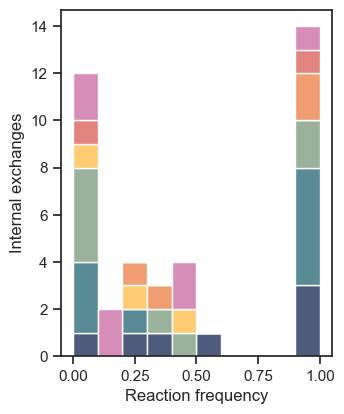

In [291]:
if step == 3:
    f = plt.figure()

    df = frac_df

    ax = sns.histplot(x=df.frac, hue=df.organism, hue_order=reversed(model_order), palette=model_palette, multiple='stack', binwidth=0.1, binrange=(0, 1))

    plt.xlabel('Reaction frequency')
    plt.ylabel('Internal exchanges')

    plt.legend([x for x in model_order], ncol=1, frameon=False).set_visible(False)

    f.set_size_inches(3.5, 4.5)
    f.savefig(join(results_dir, 'reaction_frequency_mps_' + str(step) + '.svg'), bbox_inches='tight')

In [116]:
# Compute interaction frequencies

from itertools import permutations

d = {x: defaultdict(float) for x in permutations(model_order, 2)}

step = 3

for i, s in enumerate(mps[step - 1]):
    if i and not i % 1e4:
        print(i)
    # Get consumers and producers of shared metabolites
    c = defaultdict(set)
    p = defaultdict(set)
    for x in s:
        if '_IEX_' in x:
            o = x[:2]
            x = x[7:]
            if x.endswith('_rev'):
                c[o].add(x[:-4])
            else:
                p[o].add(x)

    # Find interactions
    for x1 in p:
        for x2 in c:
            for m in p[x1] & c[x2]:
                d[(x1, x2)][m] += 1

df = pd.DataFrame(d).fillna(0)
df = df.loc[:, df.any(axis=0)]
df /= len(mp_df)

int_df = df
int_df

ST                              FP              LL                  \
           FP      EC      BT      HS      ST      HS      ST      FP      LP   
nac    0.0084  0.0000  0.0084  0.0000  0.0000  0.0000  0.0000  0.0084  0.0000   
gly    0.0132  0.0000  0.0000  0.0012  0.0000  0.0000  0.0000  0.0120  0.0000   
ala_L  0.0252  0.0252  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
etoh   0.0000  0.0252  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
for    0.0000  0.0000  0.0000  0.0024  0.0000  0.0024  0.0000  0.0000  0.0000   
acald  0.0000  0.0000  0.0000  0.0000  0.0252  0.0000  0.0000  0.0000  0.0000   
succ   0.0000  0.0000  0.0000  0.0000  0.0000  0.0024  0.0000  0.0000  0.0000   
glyc   0.0000  0.0000  0.0000  0.0000  0.0000  0.0024  0.0000  0.0000  0.0000   
ile_L  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0063  0.0063  0.0063   
orn    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0252  0.0000   
ppa    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
mal_L  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

                                   LP      EC              BT  
           EC      BT      HS      HS      FP      BT      HS  
nac    0.0000  0.0084  0.0000  0.0000  0.0084  0.0084  0.0000  
gly    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
ala_L  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
etoh   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
for    0.0000  0.0000  0.0024  0.0024  0.0000  0.0000  0.0024  
acald  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
succ   0.0000  0.0000  0.0024  0.0000  0.0000  0.0000  0.0000  
glyc   0.0000  0.0000  0.0024  0.0000  0.0000  0.0000  0.0000  
ile_L  0.0063  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
orn    0.0000  0.0000  0.0252  0.0000  0.0000  0.0000  0.0000  
ppa    0.0000  0.0000  0.0024  0.0000  0.0000  0.0000  0.0000  
mal_L  0.0000  0.0000  0.0000  0.0108  0.0000  0.0000  0.0000

/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_79184/326515340.py:2: RuntimeWarning: divide by zero encountered in log10
  ax = sns.ecdfplot(np.log10(x))


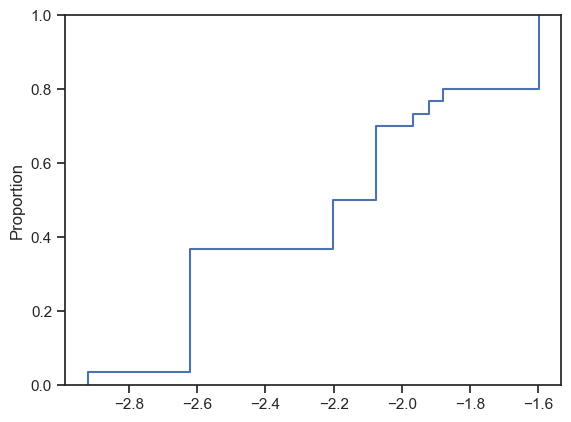

In [117]:
x = int_df.values.flatten()
ax = sns.ecdfplot(np.log10(x))

In [118]:
df = int_df.copy()

# df.columns = ['-'.join(col).strip() for col in df.columns.values]
df.index.name = 'metabolite'
df = df.reset_index()

df = df.melt(id_vars=[('metabolite',   '')])
df.columns = ['metabolite', 'producer', 'consumer', 'frac']

# df['log_frac'] = np.log10(df.frac)

df

metabolite producer consumer    frac
0          nac       ST       FP  0.0084
1          gly       ST       FP  0.0132
2        ala_L       ST       FP  0.0252
3         etoh       ST       FP  0.0000
4          for       ST       FP  0.0000
..         ...      ...      ...     ...
187       glyc       BT       HS  0.0000
188      ile_L       BT       HS  0.0000
189        orn       BT       HS  0.0000
190        ppa       BT       HS  0.0000
191      mal_L       BT       HS  0.0000

[192 rows x 4 columns]

In [119]:
# Write interaction frequency supplementary table
df['step'] = step
df = df[['step', 'metabolite', 'producer', 'consumer', 'frac']]
df.columns = list(df.columns[:-1]) + ['frequency']
df.to_excel(join(results_dir, 'host_microbe_frequency_int_' + str(step) + '.xlsx'), index=False)
df

step metabolite producer consumer  frequency
0       3        nac       ST       FP     0.0084
1       3        gly       ST       FP     0.0132
2       3      ala_L       ST       FP     0.0252
3       3       etoh       ST       FP     0.0000
4       3        for       ST       FP     0.0000
..    ...        ...      ...      ...        ...
187     3       glyc       BT       HS     0.0000
188     3      ile_L       BT       HS     0.0000
189     3        orn       BT       HS     0.0000
190     3        ppa       BT       HS     0.0000
191     3      mal_L       BT       HS     0.0000

[192 rows x 5 columns]

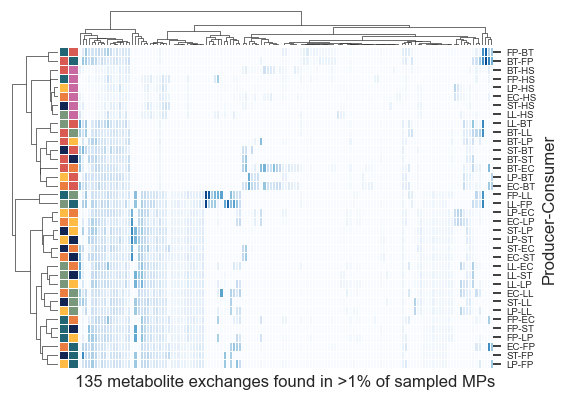

In [274]:
if step < 3:
    sns.set_theme(context='notebook', style='ticks', font_scale=1)

    df = int_df

    cut = 1e-2
    df = df[df.max(1) > cut]
    # df = df[df.sum(1) > 1e-2]
    # df = df.loc[df.max(1).sort_values(ascending=False)[:100].index]

    # df = np.log10(df).fillna(-99)
                    
    colors = [[model_palette[x[i]] for x in df.columns] for i in range(2)]
    cbar_pos = (0.02, 0.92, 0.05, 0.18)
    cbar_kws = dict(label='Frequency (%)')

    g = sns.clustermap(100 * df.T, cmap='Blues', row_colors=colors, robust=False, xticklabels=0, yticklabels=1, method='ward', figsize=(6, 4), lw=0.5, colors_ratio=0.02, dendrogram_ratio=0.1, cbar_pos=cbar_pos, cbar_kws=cbar_kws, annot=False, vmax=30)

    ax = g.ax_heatmap
    ax.set_xlabel(f'{df.shape[0]} metabolite exchanges found in >{int(100 * cut)}% of sampled MPs')
    ax.set_ylabel('Producer-Consumer')
    # ax.set_xticklabels([hm.metabolites.get_by_id(x.get_text() + '[s]') for x in ax.get_xticklabels()])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
    g.ax_cbar.set_yticks([0, 10, 20, 30])
    g.ax_cbar.set_visible(False)

    g.savefig(join(results_dir, 'interaction_heatmap_samples_' + str(step) + '.png'), dpi=300, bbox_inches='tight')

In [275]:
# Map organisms and metabolites
organisms = {
    'HS': 'Homo sapiens',
    'BT': 'Bacteroides thetaiotaomicron',
    'EC': 'Escherichia coli',
    'FP': 'Faecalibacterium prausnitzii',
    'LL': 'Lactococcus lactis',
    'LP': 'Lactobacillus plantarum',
    'ST': 'Streptococcus thermophilus',
}
mets = {
    'acald': 'acetaldehyde',
    'ala_L': 'alanine',
    'etoh': 'ethanol',
    'for': 'formate',
    'gly': 'glycine',
    'glyc': 'glycerol',
    'ile_L': 'isoleucine',
    'mal_L': 'malate',
    'nac': 'niacin',
    'orn': 'ornithine',
    'ppa': 'propionate',
    'succ': 'succinate'
}
organisms, mets

({'HS': 'Homo sapiens',
  'BT': 'Bacteroides thetaiotaomicron',
  'EC': 'Escherichia coli',
  'FP': 'Faecalibacterium prausnitzii',
  'LL': 'Lactococcus lactis',
  'LP': 'Lactobacillus plantarum',
  'ST': 'Streptococcus thermophilus'},
 {'acald': 'acetaldehyde',
  'ala_L': 'alanine',
  'etoh': 'ethanol',
  'for': 'formate',
  'gly': 'glycine',
  'glyc': 'glycerol',
  'ile_L': 'isoleucine',
  'mal_L': 'malate',
  'nac': 'niacin',
  'orn': 'ornithine',
  'ppa': 'propionate',
  'succ': 'succinate'})

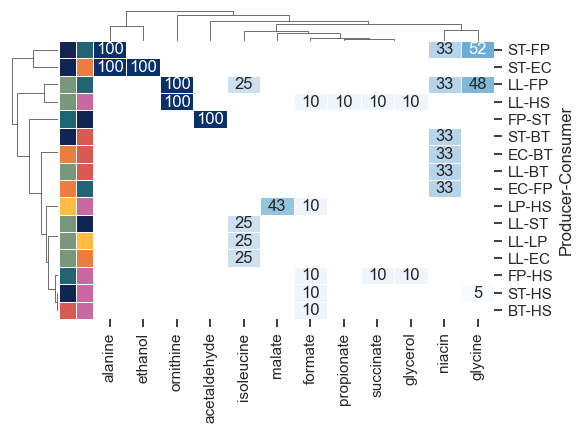

In [254]:
if step == 3:
    sns.set_theme(context='notebook', style='ticks', font_scale=1)

    df = int_df

    cut = 1e-2
    df = df[df.max(1) > cut]
    # df = df[df.sum(1) > 1e-2]
    # df = df.loc[df.max(1).sort_values(ascending=False)[:100].index]

    # df = np.log10(df).fillna(-99)

    colors = [[model_palette[x[i]] for x in df.columns] for i in range(2)]
    cbar_pos = (0.02, 0.92, 0.05, 0.18)
    cbar_kws = dict(label='Exchange\nfrequency')

    g = sns.clustermap(100 * df.T, cmap='Blues', row_colors=colors, robust=False, xticklabels=1, yticklabels=1, method='ward', figsize=(6, 4), lw=0.5, colors_ratio=0.035, dendrogram_ratio=0.1, cbar_pos=cbar_pos, cbar_kws=cbar_kws, annot=True, fmt='.0f', mask=df.T == 0)

    ax = g.ax_heatmap
    # ax.set_xlabel(f'{df.shape[0]} metabolites that are exchanged in >{int(100 * cut)}% of sampled MPs')
    ax.set_ylabel('Producer-Consumer')
    ax.set_xticklabels([mets[x.get_text()] for x in ax.get_xticklabels()], rotation=90)
    # ax.set_xticklabels([hm.metabolites.get_by_id(x.get_text() + '[s]') for x in ax.get_xticklabels()])
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    g.ax_cbar.set_visible(False)

    g.savefig(join(results_dir, 'interaction_heatmap_samples_' + str(step) + '.png'), dpi=300, bbox_inches='tight')

In [193]:
# Compute interaction frequencies

d = {x: defaultdict(float) for x in model_order}

for i, s in enumerate(samples):
    if i and not i % 1000:
        print(i)
    # Get consumers and producers of shared metabolites
    c = defaultdict(set)
    p = defaultdict(set)
    for x in s:
        if '_IEX_' in x:
            o = x[:2]
            x = x[7:]
            if x.endswith('_rev'):
                c[o].add(x[:-4])
            else:
                p[o].add(x)

    # Find interactions
    for x1 in p:
        for x2 in c:
            d[x1][x2] += len(p[x1] & c[x2])

df = pd.DataFrame(d).fillna(0)
df /= len(samples)
df

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


ST       FP       LL       LP       EC       BT   HS
HS  0.76133  0.91851  0.86310  0.73956  0.77649  0.80168  0.0
FP  2.38604  0.00000  3.88302  2.55088  2.55361  2.45681  0.0
LL  2.31521  3.66405  0.00000  2.37888  2.51879  1.61512  0.0
EC  2.31266  2.26349  2.40926  2.39747  0.00000  2.52522  0.0
ST  0.00000  2.02497  2.36955  2.25640  2.25888  1.32133  0.0
BT  1.40734  2.08751  1.69333  1.62269  2.63545  0.00000  0.0
LP  2.42043  2.44344  2.57652  0.00000  2.56255  1.36857  0.0

In [434]:
for x1 in p:
    for x2 in c:
        print(x1, x2)
        print(sorted(p[x1] & c[x2]))
        print()

FP LL
['12dgr180', '3mop', 'his_L', 'orn', 'thm']

FP FP
[]

FP ST
['glyphe', 'his_L']

FP LP
['acnam']

FP HS
['glyc', 'phe_L', 'succ']

FP EC
['cgly', 'his_L']

FP BT
['mantr', 'q8']

EC LL
['4hbz', 'gly', 'pydxn', 'ser_L']

EC FP
['pydx', 'ura']

EC ST
['pydx', 'ura']

EC LP
[]

EC HS
['etoh', 'succ']

EC EC
[]

EC BT
['lac_L', 'leu_L', 'pydxn', 'ttdca']

ST LL
['ala_L']

ST FP
['cys_L', 'thr_L']

ST ST
[]

ST LP
['lys_L']

ST HS
['for']

ST EC
['thr_L']

ST BT
['ptrc', 'thymd']

LP LL
['gly', 'tyr_L']

LP FP
[]

LP ST
['glu_L']

LP LP
[]

LP HS
[]

LP EC
['glu_L']

LP BT
['lac_L']

BT LL
['acgam', 'gcald', 'nac']

BT FP
[]

BT ST
[]

BT LP
['nac', 'val_L']

BT HS
['acgam', 'succ']

BT EC
['cytd']

BT BT
[]

LL LL
[]

LL FP
['glyleu', 'ile_L', 'sheme']

LL ST
['glyleu', 'glypro', 'metsox_S_L']

LL LP
['glypro', 'ile_L', 'metsox_S_L', 'ribflv', 'xan']

LL HS
['ile_L', 'pro_L', 'succ']

LL EC
['ile_L', 'xan']

LL BT
[]



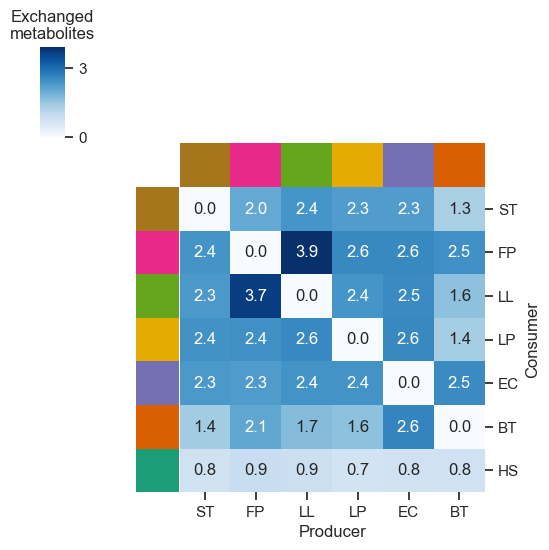

In [235]:
df = df.loc[model_order, model_order[:-1]]

row_colors = [model_palette[x] for x in df.index]
col_colors = [model_palette[x] for x in df.columns]

g = sns.clustermap(df, cmap='Blues', annot=True, fmt='.1f', col_cluster=False, row_cluster=False, col_colors=col_colors, row_colors=row_colors, colors_ratio=0.1, figsize=(5, 5))

g.ax_cbar.set_title('Exchanged\nmetabolites')
g.ax_cbar.set_yticks((0, 3))
g.ax_heatmap.set_xlabel('Producer')
g.ax_heatmap.set_ylabel('Consumer')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)

# g.savefig(join(results_dir, 'exchanges_samples_1.svg'), bbox_inches='tight')

## Old analysis

In [46]:
# Define internal and external exchanges as subset for MP enumeration
subset = [v.varName for v in model.getVars() if '_IEX_' in v.varName or ('_EX_' in v.varName and v.VarName.endswith('_rev'))]
print(len(subset))

6647


In [47]:
# Set bounds to avoid time-consuming flux variability analysis
bounds = {v.varName: (v.lb, v.ub) for v in model.getVars()}

In [120]:
# Sample minimal sets of exchanges
mps, mcs, complete = find_mps(model, subset=subset, method='iterative', tol=1e-9,
                              graph=False, random=True, bounds=bounds, inf=1000, threads=0,
                              max_mps=5, max_t=None, export=True, verbose=True)

HS_BT_EC_FP_LL_LP_ST_copy
Network size: 33296
Subset size: 6671

Making subset irreversible...

Network size: 33296
Subset size: 6671

Enumerating MPs...
1 ['BT_EX_ca2(e)_rev', 'BT_EX_cl(e)_rev', 'BT_EX_cobalt2(e)_rev', 'BT_EX_cu2(e)_rev', 'BT_EX_fe2(e)_rev', 'BT_EX_fe3(e)_rev', 'BT_EX_hspg_degr_4(e)_rev', 'BT_EX_k(e)_rev', 'BT_EX_mg2(e)_rev', 'BT_EX_mn2(e)_rev', 'BT_EX_pheme(e)_rev', 'BT_EX_pi(e)_rev', 'BT_EX_spmd(e)_rev', 'BT_EX_zn2(e)_rev', 'BT_IEX_pheme', 'BT_IEX_spmd', 'BT_IEX_trp_L', 'EC_EX_ca2(e)_rev', 'EC_EX_cl(e)_rev', 'EC_EX_cobalt2(e)_rev', 'EC_EX_cu2(e)_rev', 'EC_EX_fe2(e)_rev', 'EC_EX_fe3(e)_rev', 'EC_EX_glu_L(e)_rev', 'EC_EX_glyc3p(e)_rev', 'EC_EX_k(e)_rev', 'EC_EX_mg2(e)_rev', 'EC_EX_mn2(e)_rev', 'EC_EX_pydx(e)_rev', 'EC_EX_so4(e)_rev', 'EC_EX_zn2(e)_rev', 'EC_IEX_leu_L', 'EC_IEX_pydx', 'EC_IEX_val_L', 'FP_EX_4hbz(e)_rev', 'FP_EX_alahis(e)_rev', 'FP_EX_ca2(e)_rev', 'FP_EX_cl(e)_rev', 'FP_EX_cobalt2(e)_rev', 'FP_EX_cspg_a(e)_rev', 'FP_EX_cu2(e)_rev', 'FP_EX_fe2(e)_rev', '

5 ['BT_EX_ca2(e)_rev', 'BT_EX_cl(e)_rev', 'BT_EX_cobalt2(e)_rev', 'BT_EX_cspg_a(e)_rev', 'BT_EX_cu2(e)_rev', 'BT_EX_fe2(e)_rev', 'BT_EX_fe3(e)_rev', 'BT_EX_k(e)_rev', 'BT_EX_mg2(e)_rev', 'BT_EX_mn2(e)_rev', 'BT_EX_pheme(e)_rev', 'BT_EX_pi(e)_rev', 'BT_EX_zn2(e)_rev', 'BT_IEX_cspg_a_degr', 'BT_IEX_pheme', 'BT_IEX_spmd_rev', 'EC_EX_ca2(e)_rev', 'EC_EX_cl(e)_rev', 'EC_EX_cobalt2(e)_rev', 'EC_EX_cu2(e)_rev', 'EC_EX_fe2(e)_rev', 'EC_EX_fe3(e)_rev', 'EC_EX_k(e)_rev', 'EC_EX_mg2(e)_rev', 'EC_EX_mn2(e)_rev', 'EC_EX_nmn(e)_rev', 'EC_EX_so4(e)_rev', 'EC_EX_zn2(e)_rev', 'EC_IEX_nmn', 'FP_EX_Lcystin(e)_rev', 'FP_EX_alahis(e)_rev', 'FP_EX_ca2(e)_rev', 'FP_EX_cl(e)_rev', 'FP_EX_cobalt2(e)_rev', 'FP_EX_cu2(e)_rev', 'FP_EX_fe2(e)_rev', 'FP_EX_fe3(e)_rev', 'FP_EX_fol(e)_rev', 'FP_EX_gln_L(e)_rev', 'FP_EX_glyc3p(e)_rev', 'FP_EX_k(e)_rev', 'FP_EX_met_L(e)_rev', 'FP_EX_mg2(e)_rev', 'FP_EX_mn2(e)_rev', 'FP_EX_nac(e)_rev', 'FP_EX_pheme(e)_rev', 'FP_EX_pydx(e)_rev', 'FP_EX_q8(e)_rev', 'FP_EX_rbflvrd(e)_rev',

In [48]:
# Define internal exchanges as subset for MP enumeration
subset = [v.varName for v in model.getVars() if '_IEX_' in v.varName]
print(len(subset))

3185


In [49]:
# Set bounds to avoid time-consuming flux variability analysis
bounds = {v.varName: (v.lb, v.ub) for v in model.getVars()}

In [50]:
# Enumerate minimal sets of exchanges
mps, mcs, complete = find_mps(model, subset=subset, method='iterative', tol=1e-9,
                              graph=True, random=False, bounds=bounds, inf=1000, threads=0,
                              max_mps=None, max_t=None, export=True, verbose=True)

HS_BT_EC_FP_LL_LP_ST_constr_1
Network size: 33272
Subset size: 3185

Flux variability analysis...
0 HS_10FTHF5GLUtl (0.0, 0.17404116000051983)
1 HS_10FTHF5GLUtm (0.0, 0.17404116000051317)
2 HS_10FTHF6GLUtl (0.0, 0.08702058000173123)
3 HS_10FTHF6GLUtm (0.0, 0.0870205800141548)
4 HS_10FTHF7GLUtl (0.0, 0.05801372000095836)
5 HS_10FTHF7GLUtm (0.0, 0.058013720001156344)
6 HS_10FTHFtl (0.0, 1000.0)
7 HS_10FTHFtm (0.0, 1000.0)
8 HS_11DOCRTSLtm (0.0, 1000.0)
9 HS_11DOCRTSLtr (0.0, 1000.0)
10 HS_11DOCRTSTRNtm (0.0, 1000.0)

Interrupt request received
11 HS_11DOCRTSTRNtr (-1000.0, 1000.0)
12 HS_13DAMPPOX (0.0, 0.0)
13 HS_1a_24_25VITD2Hm (0.0, 0.0)
14 HS_1a_25VITD2Hm (0.0, 0.0)
15 HS_1MNCAMti (0.0, 0.17404116000034264)
16 HS_1PPDCRp (0.0, 0.0)
17 HS_24_25DHVITD2t (0.0, 0.0)
18 HS_24_25DHVITD2tm (0.0, 0.0)
19 HS_24_25DHVITD3t (0.0, 0.0)
20 HS_24_25DHVITD3tm (0.0, 0.0)
21 HS_24_25VITD2Hm (0.0, 0.0)
22 HS_24_25VITD3Hm (0.0, 0.0)
23 HS_24NPHte (0.0, 1000.0)
24 HS_25HVITD2t (0.0, 0.0)
25 HS_25HVITD2ti

In [18]:
# # Enumerate minimal sets of exchanges
# mps, mcs = enumerate_mps(model, subset=subset, method='iterative', tol=1e-9,
#                          graph=True, random=False, bounds=bounds, inf=1000, threads=0,
#                          max_mps=None, max_t=None, log=True, verbose=True)

HS_BT_EC_FP_LL_LP_ST
Network size: 33291
Subset size: 3209

Making subset irreversible...

Network size: 33291
Subset size: 3209

Enumerating MPs...

*
MP 1 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
New edges: 190
New cliques: 0

*
MC 1 ['FP_IEX_orn_rev']
MC 2 ['ST_IEX_ala_L']
MC 3 ['FP_IEX_nac_rev']
MC 4 ['BT_IEX_nac_rev']
MC 5 ['LL_IEX_orn']
MC 6 ['HS_IEX_orn_rev']
MC 7 ['FP_IEX_ala_L_rev']
MC 8 ['EC_IEX_ala_L_rev']
MP 2 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LL_IEX_succ', 'ST_IEX_ala_L', 'ST_IEX


*
MP 24 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
New edges: 4
New cliques: 8
MP 25 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 26 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX

MP 49 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
New edges: 5
New cliques: 0

*
MP 50 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LL_IEX_succ', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
New edges: 1
New cliques: 1
MP 51 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP

MP 73 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LL_IEX_succ', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']

*
MP 74 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
New edges: 6
New cliques: 13
MP 75 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
MP 76 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_

MP 98 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev']
MP 99 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 100 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP

MP 122 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
MP 123 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LL_IEX_succ', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 124 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LL_IEX_succ', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']

*
MC 28 ['FP_IEX_glyc', 'HS_IEX_for_rev', 'LL_IEX_succ', 'ST_IEX_gl

MP 146 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 147 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
MP 148 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 149 ['BT_IEX_nac_rev', 'EC_IEX_al

MP 171 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 172 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']

*
MP 173 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_gly_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
New edges: 2
New cliques: 16
MP 174 ['BT_IEX_

MP 196 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 197 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 198 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 199 ['BT_IEX_for'

MP 220 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 221 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 222 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']

*
M

MP 245 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
MP 246 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_ile_L_rev']
MP 247 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for'

MP 270 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 271 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 272 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP

MP 295 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_nac']
MP 296 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
MP 297 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
MP

MP 320 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_for', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 321 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_for', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 322 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 3

MP 345 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_nac']
MP 346 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 347 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP

MP 370 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']

*
MC 42 ['BT_IEX_for', 'FP_IEX_for', 'HS_IEX_mal_L_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LP_IEX_for', 'ST_IEX_for']
MC 43 ['BT_IEX_for', 'FP_IEX_for', 'LL_IEX_for', 'LL_IEX_succ', 'LP_IEX_for', 'LP_IEX_mal_L', 'ST_IEX_for']
MP 371 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
New edges: 2
New cliques: 41
MP 372 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L

MP 393 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for']
MP 394 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for']
MP 395 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh

MP 417 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 418 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 419 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 420 ['BT_IEX_nac_

MP 442 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 443 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 444 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 445 ['BT_IEX_nac_

MP 458 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 459 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 460 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
MP 461 ['BT_IEX_na

MP 483 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh']

*
MC 70 ['BT_IEX_for', 'FP_IEX_for', 'HS_IEX_gly_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LL_IEX_glyc', 'LP_IEX_for']
MC 71 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_gly_rev', 'HS_IEX_mal_L_rev', 'LL_IEX_for', 'LL_IEX_succ', 'LP_IEX_for']
MC 72 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LP_IEX_for', 'ST_IEX_for', 'ST_IEX_gly']
MC 73 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_gly_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LP_IEX_for', 'LP_IEX_mal_L']
MC 74 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'LL_IEX_for', 'LL_IEX_succ', 'LP_IEX_for', 'ST_IEX_for', 'ST_IEX_gly']
MC 75 ['BT_IEX_for', '

MP 504 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_gly']

*
MP 505 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
New edges: 1
New cliques: 3
MP 506 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_

MC 80 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_mal_L_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_succ', 'LP_IEX_for']
MC 81 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_glyc', 'LP_IEX_for', 'LP_IEX_mal_L']
MC 82 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_succ', 'LP_IEX_for', 'LP_IEX_mal_L']
MC 83 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_mal_L_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_glyc', 'LP_IEX_for']

Enumeration complete!
Runtime: 7493.46 s

MPs: 528
Reactions in MPs: 35
Mean MP size: 18.84

MCs: 83
Reactions in MCs: 35
Mean MC size: 5.65


In [93]:
# Load MPs and MCs

enum_id = 'HS_BT_EC_FP_LL_LP_ST_Tue_Apr_28_175243_2020'
# enum_id = 'HS_BT_EC_FP_LL_LP_ST_copy_20220302_144207918751'

mps = set()
with open('data/' + enum_id + '_complete_mps.csv', 'r') as f:
    for line in f:
        mps.add(frozenset(line.strip().split(',')))
        
mcs = set()
with open('data/' + enum_id + '_complete_mcs.csv', 'r') as f:
    for line in f:
        mcs.add(frozenset(line.strip().split(',')))
        
len(mps), len(mcs)

(240, 63)

In [94]:
# Load enumeration log
log_df = pd.read_csv('data/' + enum_id + '_complete_log.csv')
log_df['t'] = log_df.dt
dt = [log_df.dt[0]]
dt.extend(np.diff(log_df.dt))
log_df['dt'] = dt
# i = len(log_df)
# log_df.loc[i, :] = log_df.iloc[-1, :]
# log_df.loc[i, 'mcs'] = len(mcs)
# log_df.loc[i, 't'] = 7493.46
# log_df.loc[i, 'dt'] = log_df.loc[i, 't'] - log_df.loc[i - 1, 't']
log_df

mps  mcs  mp_size  subset_size  network_size        dt            t
0      1    0       17         3209         29712  2.733657     2.733657
1      2    5       17         3209         29712  5.293868     8.027524
2      3    5       19         3209         29712  4.086044    12.113569
3      4    7       17         3209         29712  3.931483    16.045052
4      5   13       20         3209         29712  6.802804    22.847856
..   ...  ...      ...          ...           ...       ...          ...
235  236   63       20           22         29712  6.925474  1853.722716
236  237   63       19           22         29712  3.463764  1857.186480
237  238   63       20           22         29712  7.840027  1865.026506
238  239   63       19           22         29712  2.223054  1867.249561
239  240   63       19           22         29712  8.049443  1875.299004

[240 rows x 7 columns]

In [623]:
# Total runtime in hours
log_df.t.iloc[-1] / 3600

0.5209163898891873

In [624]:
# Mean time per iteration in seconds with standard deviation
log_df.dt.mean(), log_df.dt.std()

(7.813745848337811, 3.3151478094123563)

In [625]:
# Map organisms and metabolites
organisms = {
    'HS': 'Homo sapiens',
    'BT': 'Bacteroides thetaiotaomicron',
    'EC': 'Escherichia coli',
    'FP': 'Faecalibacterium prausnitzii',
    'LL': 'Lactococcus lactis',
    'LP': 'Lactobacillus plantarum',
    'ST': 'Streptococcus thermophilus',
}
mets = {
    'ala_L': 'alanine',
    'etoh': 'ethanol',
    'for': 'formate',
    'gly': 'glycine',
    'glyc': 'glycerol',
    'ile_L': 'isoleucine',
    'mal_L': 'malate',
    'nac': 'niacin',
    'orn': 'ornithine',
    'ppa': 'propionate',
    'succ': 'succinate'
}
organisms, mets

({'HS': 'Homo sapiens',
  'BT': 'Bacteroides thetaiotaomicron',
  'EC': 'Escherichia coli',
  'FP': 'Faecalibacterium prausnitzii',
  'LL': 'Lactococcus lactis',
  'LP': 'Lactobacillus plantarum',
  'ST': 'Streptococcus thermophilus'},
 {'ala_L': 'alanine',
  'etoh': 'ethanol',
  'for': 'formate',
  'gly': 'glycine',
  'glyc': 'glycerol',
  'ile_L': 'isoleucine',
  'mal_L': 'malate',
  'nac': 'niacin',
  'orn': 'ornithine',
  'ppa': 'propionate',
  'succ': 'succinate'})

In [626]:
# Build matrix for heatmap
d = {k: defaultdict(int) for k in organisms}
for mp in mps:
    for x in mp:
        org = x[:2]
        met = x[7:]
        if x.endswith('_rev'):
            met = met[:-4]
            c = -1
        else:
            c = 1
        d[org][met] += c
mat_df = pd.DataFrame(d).fillna(0).sort_index()
mat_df

HS     BT     EC     FP     LL    LP     ST
ala_L    0.0    0.0 -240.0 -240.0    0.0   0.0  240.0
etoh     0.0    0.0 -240.0    0.0    0.0   0.0  240.0
for   -216.0   48.0    0.0   48.0   48.0  48.0   24.0
gly    -48.0    0.0 -240.0    0.0   48.0   0.0  240.0
glyc  -120.0    0.0    0.0   72.0   72.0   0.0    0.0
ile_L    0.0    0.0  -60.0  -60.0  240.0 -60.0  -60.0
mal_L  -72.0    0.0    0.0    0.0    0.0  72.0    0.0
nac      0.0 -240.0   80.0 -240.0   80.0   0.0   80.0
orn   -240.0    0.0    0.0 -240.0  240.0   0.0    0.0
succ   -12.0    0.0    0.0    0.0   12.0   0.0    0.0

<>:12: SyntaxWarning: invalid escape sequence '\P'
<>:13: SyntaxWarning: invalid escape sequence '\G'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\P'
<>:13: SyntaxWarning: invalid escape sequence '\G'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\D'
/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_24949/751934586.py:12: SyntaxWarning: invalid escape sequence '\P'
  ax = sns.lineplot(x=df.t, y=df.mps / len(mps), color='#e41a1c', label='$\\dfrac{|\Pi|}{|\Pi_\mathregular{c}|}$', lw=2)
/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_24949/751934586.py:13: SyntaxWarning: invalid escape sequence '\G'
  ax = sns.lineplot(x=df.t, y=df.mcs / len(mcs), color='#377eb8', label='$\\dfrac{|\Gamma|}{|\Gamma_\mathregular{c}|}

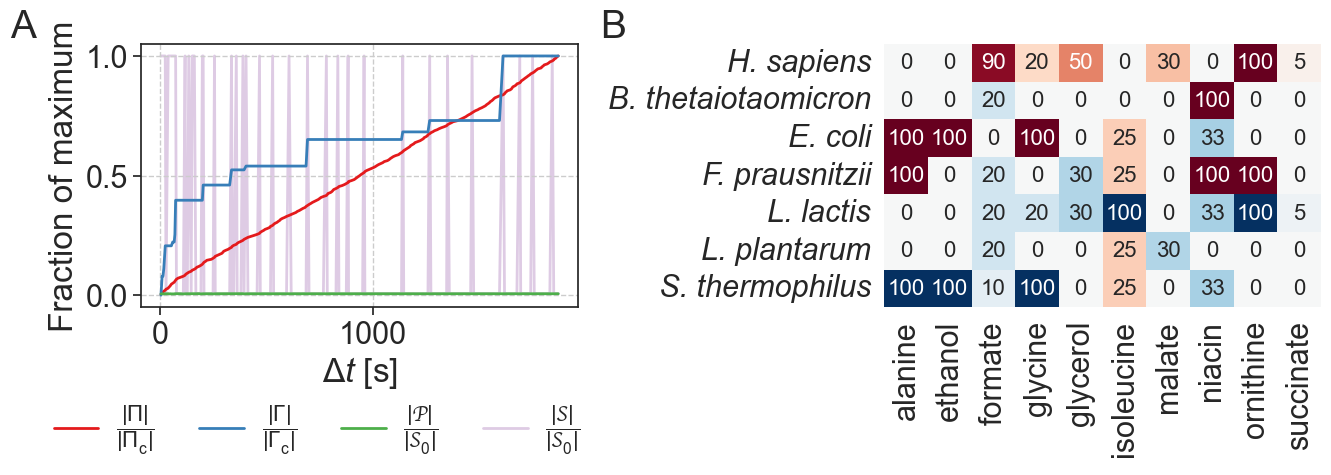

In [627]:
sns.set(style='ticks', font_scale=2)
f = plt.figure()

plt.subplot(1, 2, 1)

df = log_df

label_x = -0.5
label_y = 1.025
label_size = 28

ax = sns.lineplot(x=df.t, y=df.mps / len(mps), color='#e41a1c', label='$\\dfrac{|\Pi|}{|\Pi_\mathregular{c}|}$', lw=2)
ax = sns.lineplot(x=df.t, y=df.mcs / len(mcs), color='#377eb8', label='$\\dfrac{|\Gamma|}{|\Gamma_\mathregular{c}|}$', lw=2)
ax = sns.lineplot(x=df.t, y=df.mp_size / df.subset_size.max(), color='#4daf4a', label='$\\dfrac{|\mathcal{P}|}{|\mathcal{S}_0|}$', lw=2)
ax = sns.lineplot(x=df.t, y=df.subset_size / df.subset_size.max(), color='#decbe4', label='$\\dfrac{|\mathcal{S}|}{|\mathcal{S}_0|}$', zorder=0, lw=2)

ax.legend(frameon=False, ncol=4, loc=(-0.22, -0.6), fontsize=16)
# ax.legend(frameon=True, ncol=2, loc=(0.5, 0.07), fontsize=16)
ax.text(0.6 * label_x, label_y, 'A', transform=ax.transAxes, size=label_size)
plt.xlabel('$\Delta\it{t}$ [s]')
plt.ylabel('Fraction of maximum')
# plt.xlim(-100, 2000)
plt.grid(True, ls='--')

sns.set(font_scale=2)
plt.subplot(1, 2, 2)

ax = sns.heatmap(mat_df.T / len(mps), cmap='RdBu', annot=False, fmt='.1f', annot_kws=dict(size=16), cbar=False)
sns.heatmap((mat_df.T / len(mps)).abs() * 100, cmap='RdBu', xticklabels=1, center=0, annot=True, fmt='.0f', annot_kws=dict(size=16), cbar=False, ax=ax, alpha=0)
ax.text(label_x - 0.15, label_y, 'B', transform=ax.transAxes, size=label_size)
yticklabels = []
for x in ax.get_yticklabels():
    o = organisms[x.get_text()] 
    yticklabels.append(o[0] + '. ' + o.split(' ')[1])
# yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, rotation=0, style='italic')
# ax.set_xticks(np.arange(0.5, len(mets), 1))
ax.set_xticklabels([mets[x] for x in mat_df.index])


f.set_size_inches(14, 7)
plt.tight_layout()
plt.subplots_adjust(wspace=0.7)
# f.savefig(join(results_dir, 'fig6.pdf'), bbox_inches='tight')

In [95]:
# Build enumeration data frame
enum_df = pd.DataFrame([{x: 1 for x in s } for s in mps]).fillna(0).astype(int)
enum_df

LP_IEX_ile_L_rev  ST_IEX_ala_L  FP_IEX_orn_rev  HS_IEX_mal_L_rev  \
0                   1             1               1                 1   
1                   0             1               1                 0   
2                   0             1               1                 0   
3                   1             1               1                 0   
4                   0             1               1                 0   
..                ...           ...             ...               ...   
235                 0             1               1                 1   
236                 1             1               1                 0   
237                 1             1               1                 0   
238                 0             1               1                 1   
239                 0             1               1                 1   

     LL_IEX_ile_L  ST_IEX_gly  HS_IEX_for_rev  LL_IEX_orn  LL_IEX_for  \
0               1           1               1           1           1   
1               1           1               1           1           1   
2               1           1               1           1           0   
3               1           1               1           1           1   
4               1           1               1           1           0   
..            ...         ...             ...         ...         ...   
235             1           1               1           1           0   
236             1           1               1           1           1   
237             1           1               1           1           0   
238             1           1               0           1           0   
239             1           1               0           1           0   

     FP_IEX_ala_L_rev  ...  BT_IEX_for  LL_IEX_gly  HS_IEX_gly_rev  \
0                   1  ...           0           0               0   
1                   1  ...           0           0               0   
2                   1  ...           1           0               0   
3                   1  ...           0           1               1   
4                   1  ...           0           0               0   
..                ...  ...         ...         ...             ...   
235                 1  ...           1           0               0   
236                 1  ...           0           0               0   
237                 1  ...           1           0               0   
238                 1  ...           0           0               0   
239                 1  ...           0           0               0   

     LL_IEX_nac  ST_IEX_for  EC_IEX_ile_L_rev  FP_IEX_for  LP_IEX_for  \
0             0           0                 0           0           0   
1             0           0                 0           0           0   
2             0           0                 0           0           0   
3             1           0                 0           0           0   
4             1           1                 0           0           0   
..          ...         ...               ...         ...         ...   
235           0           0                 0           0           0   
236           0           0                 0           0           0   
237           1           0                 0           0           0   
238           1           0                 1           0           0   
239           0           0                 0           0           0   

     LL_IEX_succ  HS_IEX_succ_rev  
0              0                0  
1              0                0  
2              0                0  
3              0                0  
4              0                0  
..           ...              ...  
235            0                0  
236            0                0  
237            0                0  
238            0                0  
239            0                0  

[240 rows x 35 columns]

In [850]:
# Compute reaction frequencies
reac_frac = defaultdict(float)
reac_frac.update(dict(enum_df.sum() / len(enum_df)))
reac_frac

NameError: name 'enum_df' is not defined

In [97]:
# Classify reactions by organism and reaction type
d = defaultdict(list)
for k, v in reac_frac.items():
    d['reaction'].append(k)
    d['frac'].append(v)
    d['organism'].append(k[:2])
    if '_EX_' in k:
        kind = 'exchange (environment)'
    elif '_IEX_' in k:
        kind = 'exchange (community)'
    else:
        kind = 'intracellular'
    d['kind'].append(kind)
reac_df = pd.DataFrame(d)
reac_df

reaction      frac organism                  kind
0   LP_IEX_ile_L_rev  0.250000       LP  exchange (community)
1       ST_IEX_ala_L  1.000000       ST  exchange (community)
2     FP_IEX_orn_rev  1.000000       FP  exchange (community)
3   HS_IEX_mal_L_rev  0.300000       HS  exchange (community)
4       LL_IEX_ile_L  1.000000       LL  exchange (community)
5         ST_IEX_gly  1.000000       ST  exchange (community)
6     HS_IEX_for_rev  0.900000       HS  exchange (community)
7         LL_IEX_orn  1.000000       LL  exchange (community)
8         LL_IEX_for  0.200000       LL  exchange (community)
9   FP_IEX_ala_L_rev  1.000000       FP  exchange (community)
10       ST_IEX_etoh  1.000000       ST  exchange (community)
11    EC_IEX_gly_rev  1.000000       EC  exchange (community)
12    HS_IEX_orn_rev  1.000000       HS  exchange (community)
13  EC_IEX_ala_L_rev  1.000000       EC  exchange (community)
14      LP_IEX_mal_L  0.300000       LP  exchange (community)
15   EC_IEX_etoh_rev  1.000000       EC  exchange (community)
16        EC_IEX_nac  0.333333       EC  exchange (community)
17    FP_IEX_nac_rev  1.000000       FP  exchange (community)
18    BT_IEX_nac_rev  1.000000       BT  exchange (community)
19   HS_IEX_glyc_rev  0.500000       HS  exchange (community)
20  ST_IEX_ile_L_rev  0.250000       ST  exchange (community)
21        ST_IEX_nac  0.333333       ST  exchange (community)
22       FP_IEX_glyc  0.300000       FP  exchange (community)
23  FP_IEX_ile_L_rev  0.250000       FP  exchange (community)
24       LL_IEX_glyc  0.300000       LL  exchange (community)
25        BT_IEX_for  0.200000       BT  exchange (community)
26        LL_IEX_gly  0.200000       LL  exchange (community)
27    HS_IEX_gly_rev  0.200000       HS  exchange (community)
28        LL_IEX_nac  0.333333       LL  exchange (community)
29        ST_IEX_for  0.100000       ST  exchange (community)
30  EC_IEX_ile_L_rev  0.250000       EC  exchange (community)
31        FP_IEX_for  0.200000       FP  exchange (community)
32        LP_IEX_for  0.200000       LP  exchange (community)
33       LL_IEX_succ  0.050000       LL  exchange (community)
34   HS_IEX_succ_rev  0.050000       HS  exchange (community)

/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_13194/3318745856.py:21: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(y=df.kind, x=np.log10(df.frac), hue=df.organism, orient='h', hue_order=model_order, palette=model_palette, dodge=0.7, scale=0.7)
/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_13194/3318745856.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([x.get_text().replace(' ', '\n') for x in ax.get_yticklabels()])


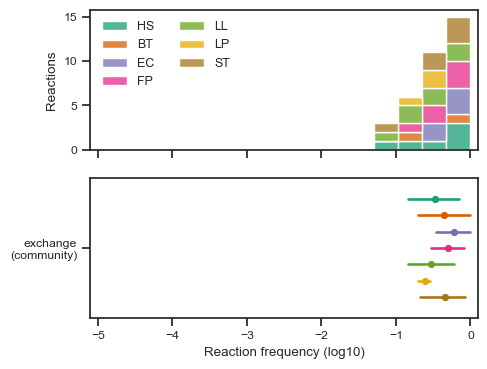

In [98]:
df = reac_df

f = plt.figure()

xlim = -5.1, 0.1

plt.subplot(2, 1, 1)

ax = sns.histplot(x=np.log10(df.frac), hue=df.organism, hue_order=reversed(model_order), data=df, palette=model_palette, multiple='stack', bins=4)
plt.legend([x for x in model_order], ncol=2, fontsize=9, frameon=False)

plt.xlim(xlim)
plt.xlabel('')
plt.ylabel('Reactions')
ax.set_xticklabels([])

plt.subplot(2, 1, 2)

df = df.sort_values(by='kind', ascending=False)

ax = sns.pointplot(y=df.kind, x=np.log10(df.frac), hue=df.organism, orient='h', hue_order=model_order, palette=model_palette, dodge=0.7, scale=0.7)
# ax = sns.stripplot(y=df.kind, x=np.log10(df.frac), hue=df.organism, orient='h', hue_order=model_order, palette='Set2', dodge=True, zorder=-1, alpha=1)

plt.xlim(xlim)
plt.xlabel('Reaction frequency (log10)')
plt.ylabel('')
ax.set_yticklabels([x.get_text().replace(' ', '\n') for x in ax.get_yticklabels()])

ax.legend(loc=(1.1, 0.5)).set_visible(False)

f.set_size_inches(5, 4)

In [304]:
# Compute interaction frequencies

d = {x: defaultdict(float) for x in permutations(model_order, 2)}

for s in mps:
    # Get consumers and producers of shared metabolites
    c = defaultdict(set)
    p = defaultdict(set)
    for x in s:
        if '_IEX_' in x:
            o = x[:2]
            x = x[7:]
            if x.endswith('_rev'):
                c[o].add(x[:-4])
            else:
                p[o].add(x)

    # Find interactions
    for x1 in p:
        for x2 in c:
            for m in p[x1] & c[x2]:
                d[(x1, x2)][m] += 1

df = pd.DataFrame(d).fillna(0)
df = df.loc[:, df.any(axis=0)]
df /= len(enum_df)

int_df = df
int_df

NameError: name 'enum_df' is not defined

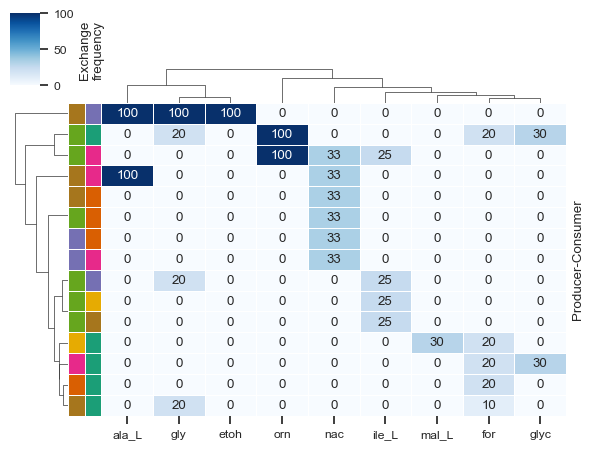

In [101]:
sns.set_theme(context='notebook', style='ticks', font_scale=0.8)

df = int_df
df = df[df.max(1) > 0.1]

colors = [[model_palette[x[i]] for x in int_df.columns] for i in range(2)]
cbar_pos = (0.02, 0.92, 0.05, 0.18)
cbar_kws = dict(label='Exchange\nfrequency')

g = sns.clustermap(100 * df.T, cmap='Blues', row_colors=col
ors, robust=True, xticklabels=1, yticklabels=0, method='ward', figsize=(6, 4), lw=0.5, dendrogram_ratio=0.1, cbar_pos=cbar_pos, cbar_kws=cbar_kws, annot=True, fmt='.0f')

ax = g.ax_heatmap
ax.set_ylabel('Producer-Consumer')
# ax.set_xticklabels([hm.metabolites.get_by_id(x.get_text() + '[s]') for x in ax.get_xticklabels()])

g.savefig(join(results_dir, 'interaction_heatmap_enumerated.svg'), dpi=300, bbox_inches='tight')